# First we will run experiments on using six landmarks only. We will use the folds that were created. 
# We will edit these parameters to see what works best: 
- learning rate
- augmentations / no augmentations
- model space for LSTM cell 

In [1]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [4]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [3]:
from glob import glob
def cross_validate(model, epochs = 50, callbacks=[]):
    for i in range(X.shape[0]): 
        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)

        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [6]:
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=False), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

class acc_Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') >= 0.900):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True
            predictions = []
            for file in glob("*.mov"):
                predictions.append(predict_on_video(self.model, file))
            predictions = np.array(predictions).flatten() 
            if predictions == np.array([0, 1, 0, 1, 0, 1]): 
                self.model.save("90%_model")
            else: 
                print("not there yet")

accuracy_callback = acc_Callback()

using no aug with lr 0.01
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/50
3/3 [==============================] - 1s 236ms/step - loss: 0.6949 - accuracy: 0.4875 - val_loss: 0.6714 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6807 - accuracy: 0.6375 - val_loss: 0.6700 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6459 - accuracy: 0.6875 - val_loss: 0.6073 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 124ms/step - loss: 0.6108 - accuracy: 0.7250 - val_loss: 0.6012 - val_accuracy: 0.6500
Epoch 5/50
3/3 [=============

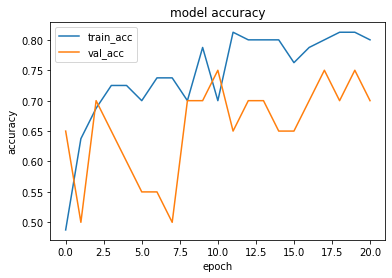

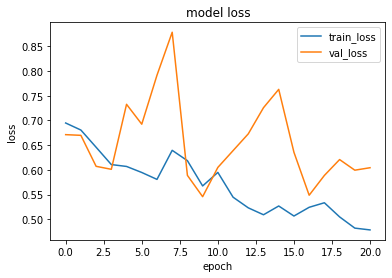

1it [00:00, 4310.69it/s]
file is another_control.mov, prediction is [[0.22012013]]
1it [00:00, 16644.06it/s]
file is short_armflapping.mov, prediction is [[0.74745584]]
1it [00:00, 19691.57it/s]
file is control_far.mov, prediction is [[0.18183315]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.5663521]]
1it [00:00, 16070.13it/s]
file is me_reading_control.mov, prediction is [[0.1768387]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.78812623]]
Epoch 1/50
3/3 [==============================] - 0s 131ms/step - loss: 0.5091 - accuracy: 0.7875 - val_loss: 0.4605 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.4986 - accuracy: 0.7750 - val_loss: 0.5130 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 124ms/step - loss: 0.4856 - accuracy: 0.8000 - val_loss: 0.4955 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 119ms/step - loss: 0.4806

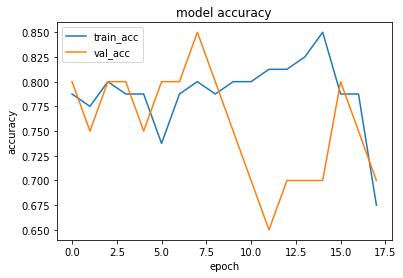

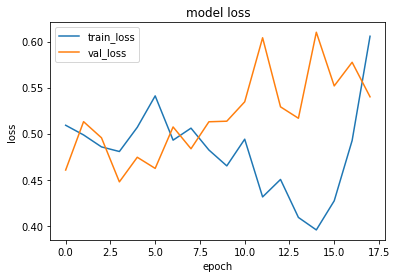

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.36472952]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.6575089]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.33791092]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.41996577]]
1it [00:00, 17549.39it/s]
file is me_reading_control.mov, prediction is [[0.33317614]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.5917784]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5328 - accuracy: 0.7000 - val_loss: 0.5817 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 128ms/step - loss: 0.5292 - accuracy: 0.7625 - val_loss: 0.6081 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 124ms/step - loss: 0.5302 - accuracy: 0.7750 - val_loss: 0.6013 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 0.496

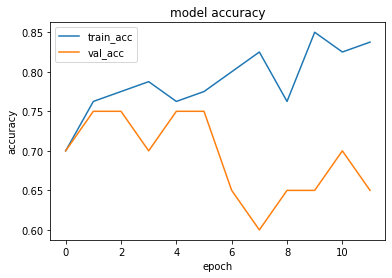

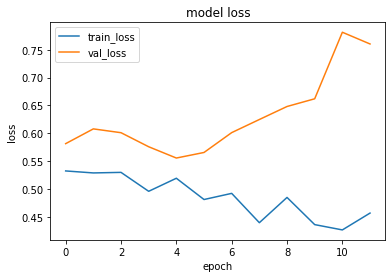

1it [00:00, 10591.68it/s]
file is another_control.mov, prediction is [[0.29812753]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.73016125]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.28508016]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.47262323]]
1it [00:00, 16194.22it/s]
file is me_reading_control.mov, prediction is [[0.2816256]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.8458319]]
Epoch 1/50
3/3 [==============================] - 0s 141ms/step - loss: 0.4839 - accuracy: 0.7625 - val_loss: 0.4865 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.5392 - accuracy: 0.7750 - val_loss: 0.5089 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 128ms/step - loss: 0.4642 - accuracy: 0.7625 - val_loss: 0.4944 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.453

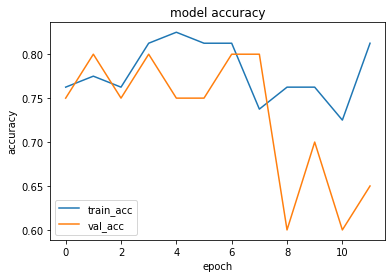

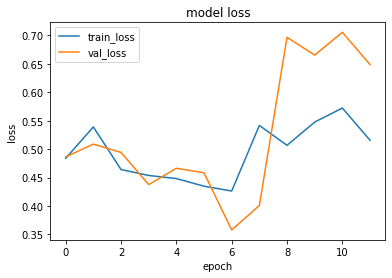

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.36484075]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.91618955]]
1it [00:00, 19508.39it/s]
file is control_far.mov, prediction is [[0.3118804]]
1it [00:00, 20360.70it/s]
file is long_armflapping.mov, prediction is [[0.87371117]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.38369048]]
1it [00:00, 18558.87it/s]file is me_armflapping.mov, prediction is [[0.83005977]]
Epoch 1/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6015 - accuracy: 0.6625 - val_loss: 0.4328 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6647 - accuracy: 0.6500 - val_loss: 0.4865 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6200 - accuracy: 0.7125 - val_loss: 0.4760 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 126ms/step - loss: 0.588

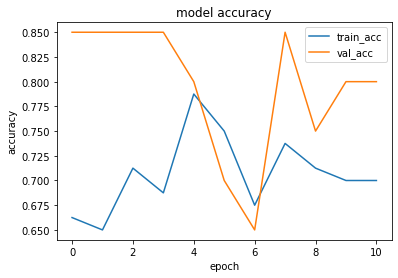

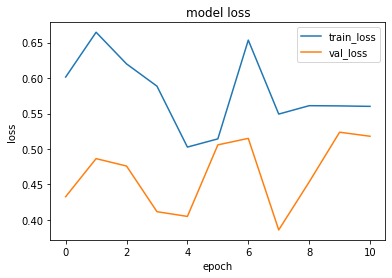

1it [00:00, 15650.39it/s]
file is another_control.mov, prediction is [[0.3937186]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.6128001]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.38225982]]
1it [00:00, 19239.93it/s]
file is long_armflapping.mov, prediction is [[0.4266153]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.37914577]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.5731732]]
using no aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 225ms/step - loss: 0.6985 - accuracy: 0.3625 - val_loss: 0.6927 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6912 - accuracy: 0.3125 - val_loss: 0.6884 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6905 - accuracy: 0.6000 - val_loss: 0.6839 - val_accuracy: 0.4000
Epoch 4/50
3/3 [==============================] - 0s

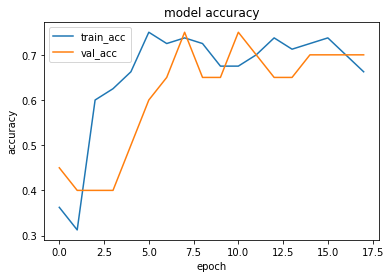

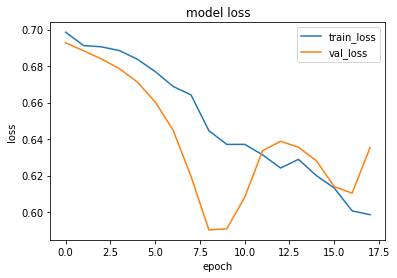

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.21523175]]
1it [00:00, 19239.93it/s]
file is short_armflapping.mov, prediction is [[0.42992878]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.19976133]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.27717537]]
1it [00:00, 19239.93it/s]
file is me_reading_control.mov, prediction is [[0.23346487]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.4471433]]
Epoch 1/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6071 - accuracy: 0.7000 - val_loss: 0.5814 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6092 - accuracy: 0.6875 - val_loss: 0.5740 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.5925 - accuracy: 0.7125 - val_loss: 0.5732 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.59

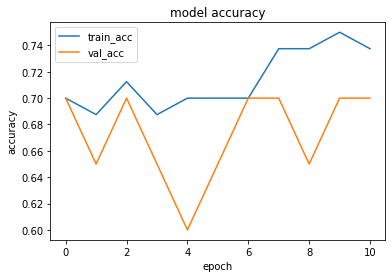

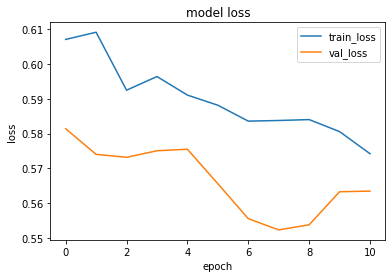

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.34602213]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.5675088]]
1it [00:00, 17772.47it/s]
file is control_far.mov, prediction is [[0.24171165]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.49457788]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.35691518]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.62400484]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.5674 - accuracy: 0.7125 - val_loss: 0.5668 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5728 - accuracy: 0.7000 - val_loss: 0.5659 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5657 - accuracy: 0.7250 - val_loss: 0.5560 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 131ms/step - loss: 0.54

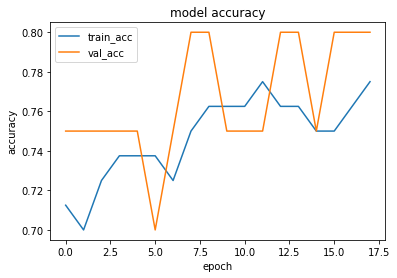

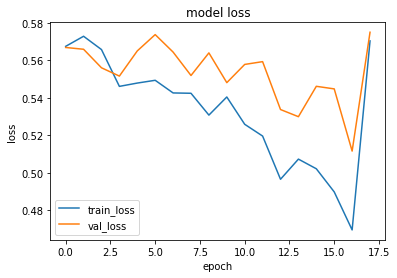

1it [00:00, 6584.46it/s]
file is another_control.mov, prediction is [[0.02343053]]
1it [00:00, 17623.13it/s]
file is short_armflapping.mov, prediction is [[0.66575944]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.02031779]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.57993686]]
1it [00:00, 16384.00it/s]
file is me_reading_control.mov, prediction is [[0.03938532]]
1it [00:00, 15650.39it/s]
file is me_armflapping.mov, prediction is [[0.63869274]]
Epoch 1/50
3/3 [==============================] - 0s 149ms/step - loss: 0.7350 - accuracy: 0.7125 - val_loss: 0.4521 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 145ms/step - loss: 0.5315 - accuracy: 0.7375 - val_loss: 0.6253 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.5446 - accuracy: 0.7375 - val_loss: 0.7551 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 134ms/step - loss: 0.55

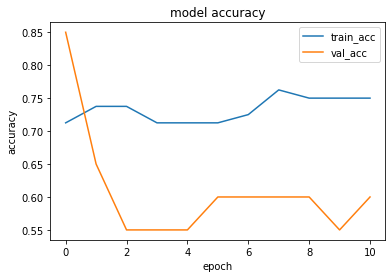

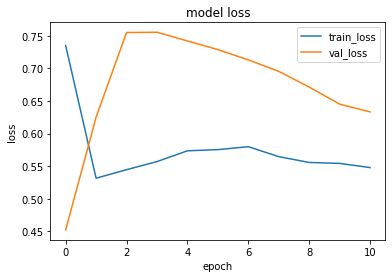

1it [00:00, 18477.11it/s]
file is another_control.mov, prediction is [[0.4674517]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.5729045]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.45146674]]
1it [00:00, 17331.83it/s]
file is long_armflapping.mov, prediction is [[0.527345]]
1it [00:00, 16644.06it/s]
file is me_reading_control.mov, prediction is [[0.42232835]]
1it [00:00, 15363.75it/s]
file is me_armflapping.mov, prediction is [[0.6116845]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5693 - accuracy: 0.7375 - val_loss: 0.5351 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5559 - accuracy: 0.7250 - val_loss: 0.5876 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5485 - accuracy: 0.7250 - val_loss: 0.7102 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 149ms/step - loss: 0.5640 -

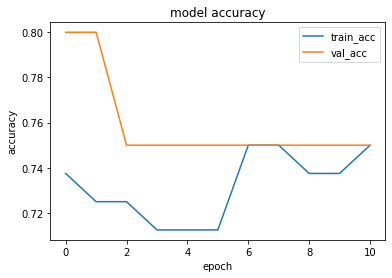

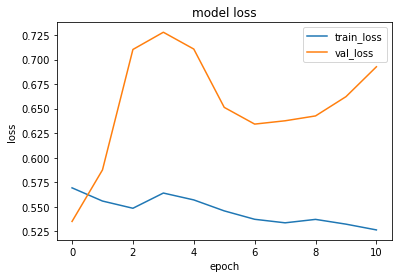

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.03502211]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.64632076]]
1it [00:00, 16448.25it/s]
file is control_far.mov, prediction is [[0.03093332]]
1it [00:00, 16980.99it/s]
file is long_armflapping.mov, prediction is [[0.56516504]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.10448951]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.6867137]]
using no aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 238ms/step - loss: 0.6928 - accuracy: 0.3750 - val_loss: 0.6880 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6906 - accuracy: 0.5000 - val_loss: 0.6861 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6891 - accuracy: 0.6750 - val_loss: 0.6843 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] 

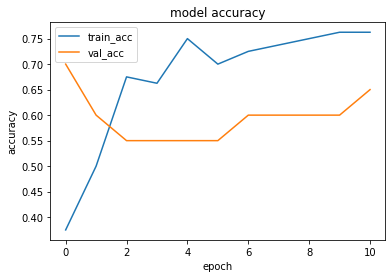

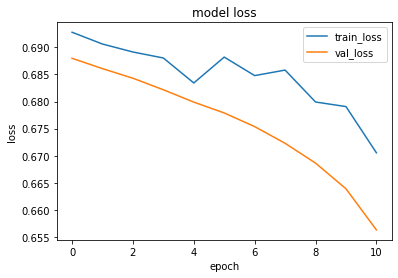

1it [00:00, 18558.87it/s]
file is another_control.mov, prediction is [[0.49251908]]
1it [00:00, 16980.99it/s]
file is short_armflapping.mov, prediction is [[0.50103873]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.49051535]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.497827]]
1it [00:00, 17772.47it/s]
file is me_reading_control.mov, prediction is [[0.48937833]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.51332814]]
Epoch 1/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6703 - accuracy: 0.6875 - val_loss: 0.6561 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6643 - accuracy: 0.7000 - val_loss: 0.6469 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6505 - accuracy: 0.7125 - val_loss: 0.6357 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 142ms/step - loss: 0.639

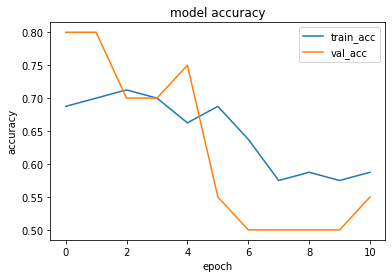

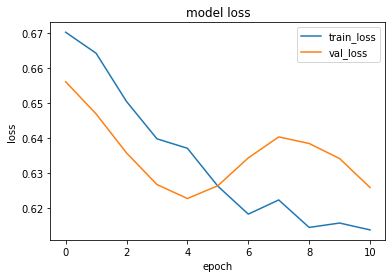

1it [00:00, 18558.87it/s]
file is another_control.mov, prediction is [[0.51597655]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.5707395]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.5086046]]
1it [00:00, 17924.38it/s]
file is long_armflapping.mov, prediction is [[0.54079586]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.5065167]]
1it [00:00, 13148.29it/s]
file is me_armflapping.mov, prediction is [[0.5974456]]
Epoch 1/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6134 - accuracy: 0.6000 - val_loss: 0.6087 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6121 - accuracy: 0.6500 - val_loss: 0.6150 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6033 - accuracy: 0.7000 - val_loss: 0.6268 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 1s 192ms/step - loss: 0.6142 

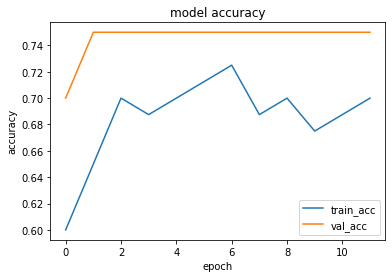

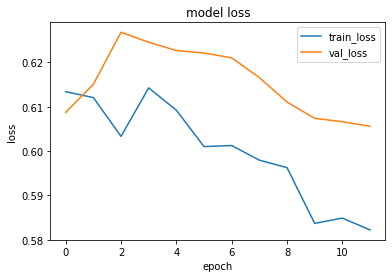

1it [00:00, 14716.86it/s]
file is another_control.mov, prediction is [[0.43392015]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.54156995]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.42407203]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.48161045]]
1it [00:00, 15650.39it/s]
file is me_reading_control.mov, prediction is [[0.40843013]]
1it [00:00, 19239.93it/s]
file is me_armflapping.mov, prediction is [[0.5914481]]
Epoch 1/50
3/3 [==============================] - 0s 157ms/step - loss: 0.5604 - accuracy: 0.7375 - val_loss: 0.6506 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 142ms/step - loss: 0.5605 - accuracy: 0.7500 - val_loss: 0.6577 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5443 - accuracy: 0.7750 - val_loss: 0.6717 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 142ms/step - loss: 0.54

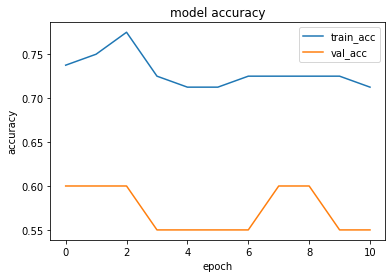

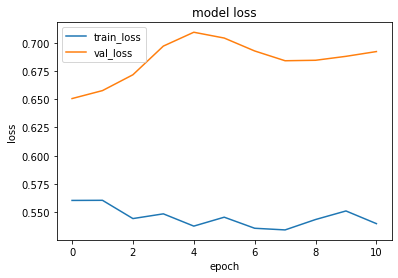

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.0134685]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.65754485]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.0132603]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.54327595]]
1it [00:00, 17549.39it/s]
file is me_reading_control.mov, prediction is [[0.01570651]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.7045863]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.5685 - accuracy: 0.6750 - val_loss: 0.5192 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 148ms/step - loss: 0.5636 - accuracy: 0.7000 - val_loss: 0.4546 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.5608 - accuracy: 0.7000 - val_loss: 0.6619 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 141ms/step - loss: 0.5648

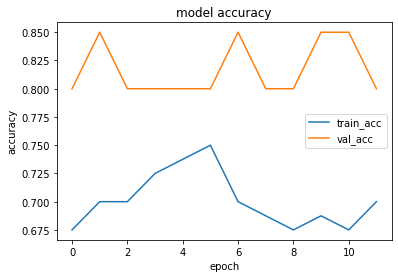

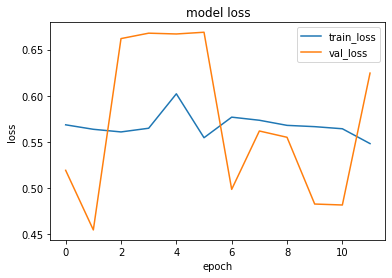

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.27815428]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.6082449]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.02947363]]
1it [00:00, 16710.37it/s]
file is long_armflapping.mov, prediction is [[0.5319529]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.39502716]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.6499299]]
using no aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 237ms/step - loss: 0.6913 - accuracy: 0.4875 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6898 - accuracy: 0.6750 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6922 - accuracy: 0.6875 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 

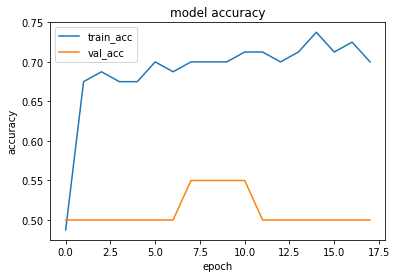

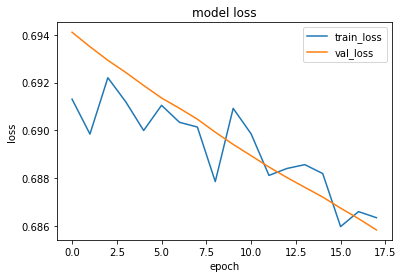

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.49622443]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.50389457]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.49470234]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.49940345]]
1it [00:00, 12520.31it/s]
file is me_reading_control.mov, prediction is [[0.49441662]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.50196624]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.6863 - accuracy: 0.6625 - val_loss: 0.6838 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6869 - accuracy: 0.6375 - val_loss: 0.6834 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 152ms/step - loss: 0.6834 - accuracy: 0.6875 - val_loss: 0.6829 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.6

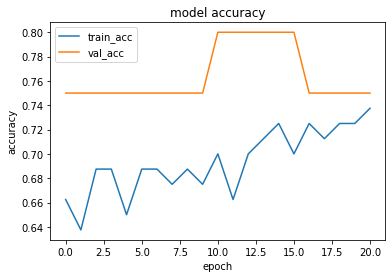

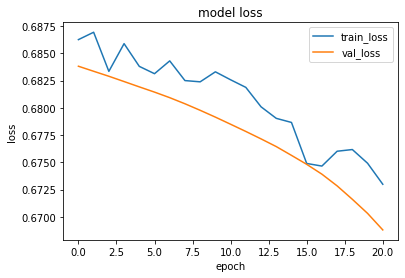

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.49641925]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.5066274]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.4944359]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.50126064]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.49364948]]
1it [00:00, 17189.77it/s]
file is me_armflapping.mov, prediction is [[0.50707304]]
Epoch 1/50
3/3 [==============================] - 0s 165ms/step - loss: 0.6718 - accuracy: 0.7250 - val_loss: 0.6714 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 154ms/step - loss: 0.6691 - accuracy: 0.7000 - val_loss: 0.6696 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6635 - accuracy: 0.7375 - val_loss: 0.6675 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 150ms/step - loss: 0.662

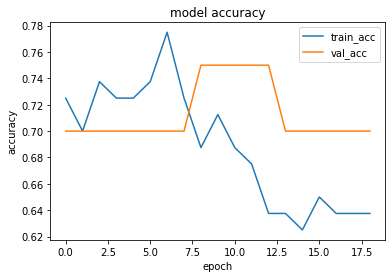

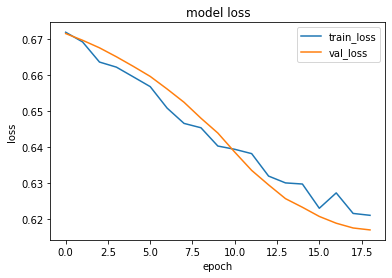

1it [00:00, 18236.10it/s]
file is another_control.mov, prediction is [[0.50113326]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.5463381]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.49517772]]
1it [00:00, 17772.47it/s]
file is long_armflapping.mov, prediction is [[0.5196895]]
1it [00:00, 17189.77it/s]
file is me_reading_control.mov, prediction is [[0.4977389]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.5521498]]
Epoch 1/50
3/3 [==============================] - 0s 162ms/step - loss: 0.6105 - accuracy: 0.6500 - val_loss: 0.6696 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6138 - accuracy: 0.6375 - val_loss: 0.6770 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 153ms/step - loss: 0.6059 - accuracy: 0.6375 - val_loss: 0.6870 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6017 

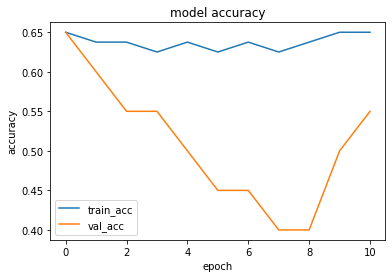

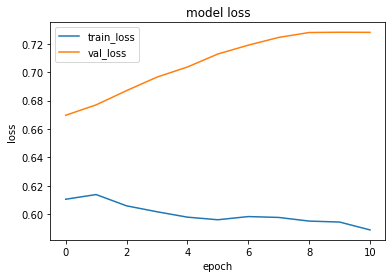

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.48746052]]
1it [00:00, 18641.35it/s]
file is short_armflapping.mov, prediction is [[0.5729541]]
1it [00:00, 17189.77it/s]
file is control_far.mov, prediction is [[0.4746519]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.5234561]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.49001747]]
1it [00:00, 17476.27it/s]
file is me_armflapping.mov, prediction is [[0.57714355]]
Epoch 1/50
3/3 [==============================] - 0s 167ms/step - loss: 0.6258 - accuracy: 0.6000 - val_loss: 0.5790 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6239 - accuracy: 0.6000 - val_loss: 0.5826 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 1s 197ms/step - loss: 0.6189 - accuracy: 0.6375 - val_loss: 0.5958 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6046

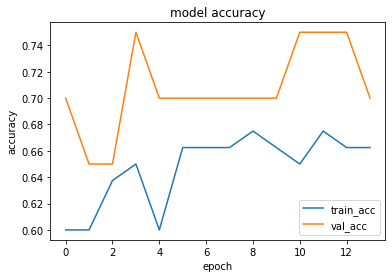

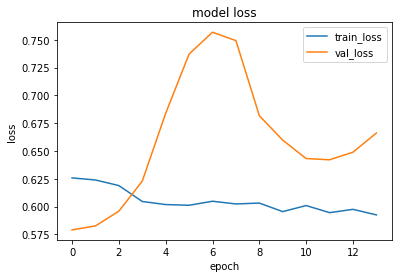

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.44872373]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.5357388]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.43510044]]
1it [00:00, 18558.87it/s]
file is long_armflapping.mov, prediction is [[0.48656836]]
1it [00:00, 17772.47it/s]
file is me_reading_control.mov, prediction is [[0.4511996]]
1it [00:00, 18724.57it/s]
file is me_armflapping.mov, prediction is [[0.5423152]]
using aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 232ms/step - loss: 0.6883 - accuracy: 0.6375 - val_loss: 0.6816 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6979 - accuracy: 0.5875 - val_loss: 0.6707 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6458 - accuracy: 0.6125 - val_loss: 0.6359 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 15

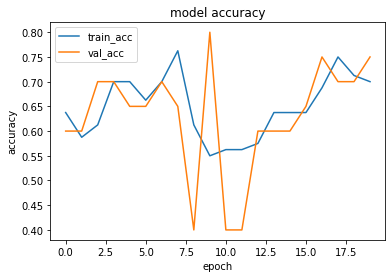

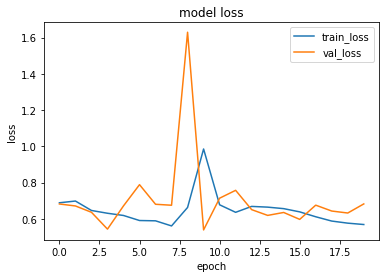

1it [00:00, 15887.52it/s]
file is another_control.mov, prediction is [[0.13817161]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.5139744]]
1it [00:00, 12052.60it/s]
file is control_far.mov, prediction is [[0.12914586]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.38008213]]
1it [00:00, 17924.38it/s]
file is me_reading_control.mov, prediction is [[0.1965819]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.5947557]]
Epoch 1/50
3/3 [==============================] - 0s 171ms/step - loss: 0.5896 - accuracy: 0.7250 - val_loss: 0.5555 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 154ms/step - loss: 0.5802 - accuracy: 0.7125 - val_loss: 0.5734 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 153ms/step - loss: 0.5921 - accuracy: 0.7000 - val_loss: 0.5383 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 153ms/step - loss: 0.5793

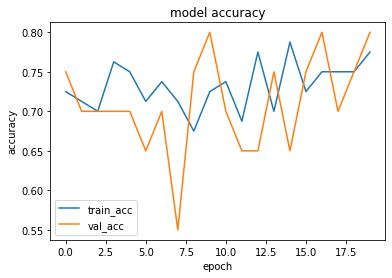

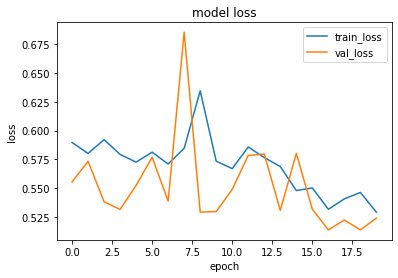

1it [00:00, 18641.35it/s]
file is another_control.mov, prediction is [[0.34030566]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.58171403]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.29053622]]
1it [00:00, 14716.86it/s]
file is long_armflapping.mov, prediction is [[0.58739114]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.30174983]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.6470798]]
Epoch 1/50
3/3 [==============================] - 0s 165ms/step - loss: 0.4926 - accuracy: 0.7750 - val_loss: 0.6021 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 164ms/step - loss: 0.5031 - accuracy: 0.7750 - val_loss: 0.6773 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 156ms/step - loss: 0.5252 - accuracy: 0.7500 - val_loss: 0.6856 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 157ms/step - loss: 0.50

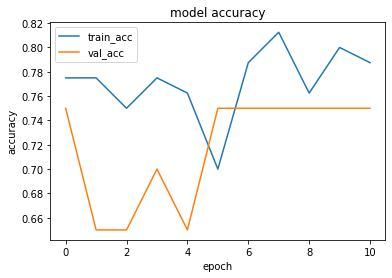

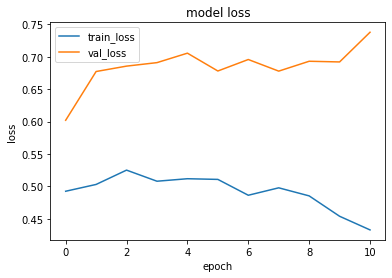

1it [00:00, 18558.87it/s]
file is another_control.mov, prediction is [[0.34452033]]
1it [00:00, 12052.60it/s]
file is short_armflapping.mov, prediction is [[0.5188094]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.28548628]]
1it [00:00, 16912.52it/s]
file is long_armflapping.mov, prediction is [[0.5574582]]
1it [00:00, 16320.25it/s]
file is me_reading_control.mov, prediction is [[0.28464597]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.67426777]]
Epoch 1/50
3/3 [==============================] - 1s 213ms/step - loss: 0.5050 - accuracy: 0.7625 - val_loss: 0.4276 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 152ms/step - loss: 0.4889 - accuracy: 0.7625 - val_loss: 0.4261 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 158ms/step - loss: 0.4795 - accuracy: 0.7875 - val_loss: 0.4334 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 158ms/step - loss: 0.474

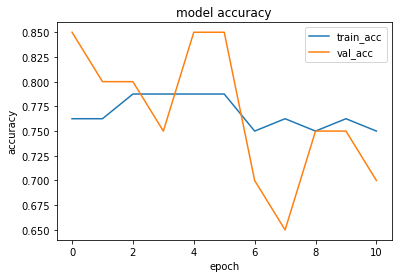

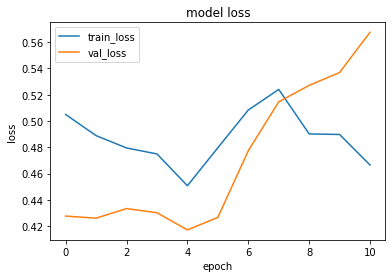

1it [00:00, 17772.47it/s]
file is another_control.mov, prediction is [[0.3118562]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.86259377]]
1it [00:00, 17924.38it/s]
file is control_far.mov, prediction is [[0.30033946]]
1it [00:00, 16384.00it/s]
file is long_armflapping.mov, prediction is [[0.36468732]]
1it [00:00, 18808.54it/s]
file is me_reading_control.mov, prediction is [[0.2971677]]
1it [00:00, 18893.26it/s]
file is me_armflapping.mov, prediction is [[0.86629677]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5096 - accuracy: 0.7500 - val_loss: 0.4548 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 160ms/step - loss: 0.4984 - accuracy: 0.7500 - val_loss: 0.4053 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 146ms/step - loss: 0.4934 - accuracy: 0.7875 - val_loss: 0.5040 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.534

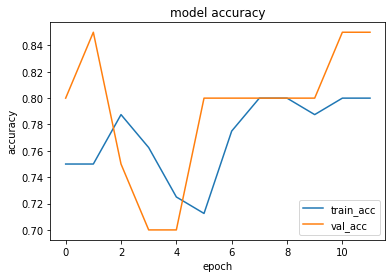

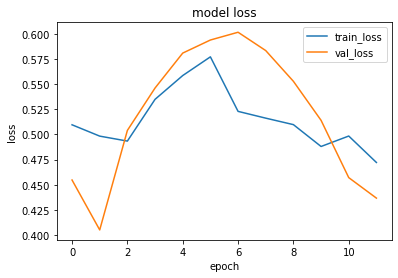

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.2834623]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.7317196]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.26842368]]
1it [00:00, 16131.94it/s]
file is long_armflapping.mov, prediction is [[0.5580549]]
1it [00:00, 17189.77it/s]
file is me_reading_control.mov, prediction is [[0.19558746]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.7818706]]
using aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 253ms/step - loss: 0.7014 - accuracy: 0.4500 - val_loss: 0.7049 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 154ms/step - loss: 0.6991 - accuracy: 0.5250 - val_loss: 0.7006 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6931 - accuracy: 0.5250 - val_loss: 0.6969 - val_accuracy: 0.3500
Epoch 4/50
3/3 [==============================] - 0s 15

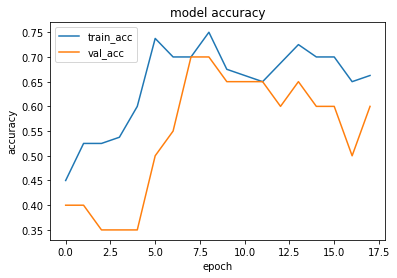

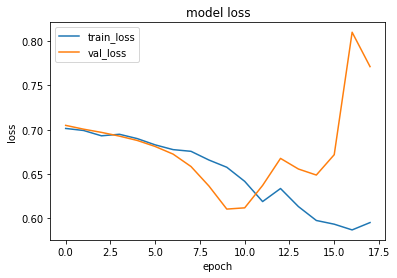

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.09576657]]
1it [00:00, 16131.94it/s]
file is short_armflapping.mov, prediction is [[0.19754559]]
1it [00:00, 15363.75it/s]
file is control_far.mov, prediction is [[0.09274063]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.10899514]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.09815371]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.14432263]]
Epoch 1/50
3/3 [==============================] - 1s 177ms/step - loss: 0.6217 - accuracy: 0.6625 - val_loss: 0.5790 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6007 - accuracy: 0.6625 - val_loss: 0.6022 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6078 - accuracy: 0.6875 - val_loss: 0.6107 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6

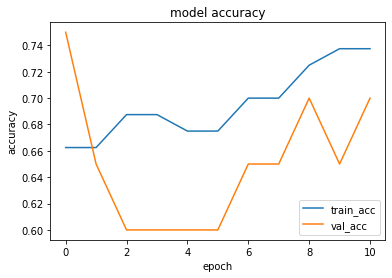

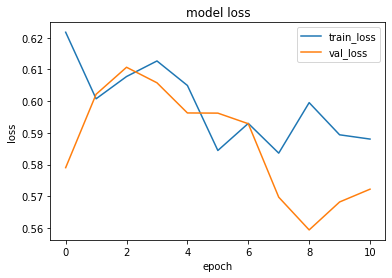

1it [00:00, 18893.26it/s]
file is another_control.mov, prediction is [[0.38773668]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.56247205]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.32291716]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.5012848]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.39969158]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.62224346]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5707 - accuracy: 0.7375 - val_loss: 0.5779 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 158ms/step - loss: 0.5700 - accuracy: 0.7250 - val_loss: 0.5717 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5645 - accuracy: 0.7125 - val_loss: 0.5629 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 151ms/step - loss: 0.54

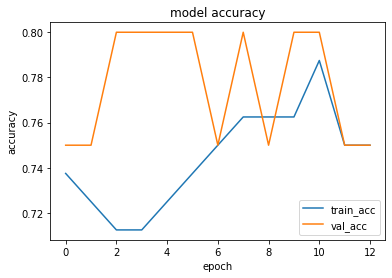

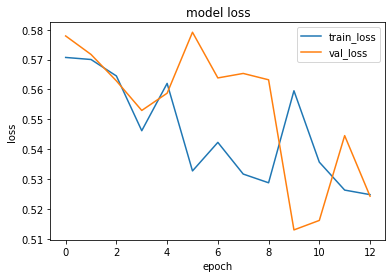

1it [00:00, 17772.47it/s]
file is another_control.mov, prediction is [[0.05604094]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.63553643]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.04760745]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.5796784]]
1it [00:00, 17772.47it/s]
file is me_reading_control.mov, prediction is [[0.2256906]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.64264166]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5170 - accuracy: 0.7500 - val_loss: 0.5262 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 141ms/step - loss: 0.5089 - accuracy: 0.7625 - val_loss: 0.5721 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 163ms/step - loss: 0.5016 - accuracy: 0.7500 - val_loss: 0.5652 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 149ms/step - loss: 0.531

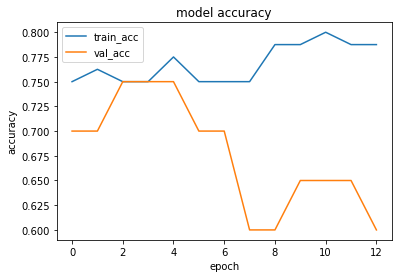

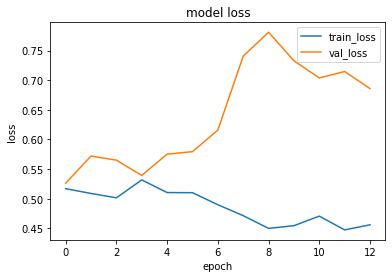

1it [00:00, 17623.13it/s]
file is another_control.mov, prediction is [[0.57651156]]
1it [00:00, 18236.10it/s]
file is short_armflapping.mov, prediction is [[0.6876903]]
1it [00:00, 14768.68it/s]
file is control_far.mov, prediction is [[0.58075833]]
1it [00:00, 15650.39it/s]
file is long_armflapping.mov, prediction is [[0.5704473]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.12121612]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.60398877]]
Epoch 1/50
3/3 [==============================] - 0s 169ms/step - loss: 0.5097 - accuracy: 0.7000 - val_loss: 0.4602 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 1s 205ms/step - loss: 0.5125 - accuracy: 0.7250 - val_loss: 0.4657 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 154ms/step - loss: 0.5189 - accuracy: 0.7250 - val_loss: 0.4636 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 153ms/step - loss: 0.522

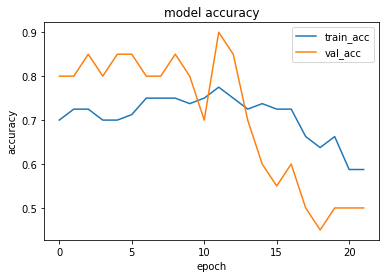

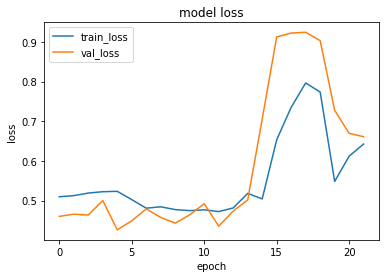

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.5926168]]
1it [00:00, 17476.27it/s]
file is short_armflapping.mov, prediction is [[0.6193094]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.5710161]]
1it [00:00, 18236.10it/s]
file is long_armflapping.mov, prediction is [[0.6232758]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.5659825]]
1it [00:00, 17476.27it/s]
file is me_armflapping.mov, prediction is [[0.6588154]]
using aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 256ms/step - loss: 0.6896 - accuracy: 0.5125 - val_loss: 0.6866 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 1s 199ms/step - loss: 0.6891 - accuracy: 0.6000 - val_loss: 0.6834 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6869 - accuracy: 0.6000 - val_loss: 0.6803 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 164

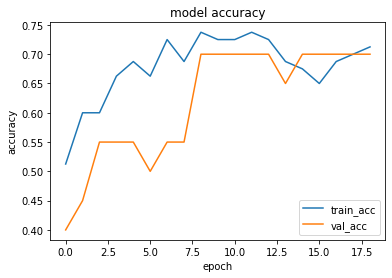

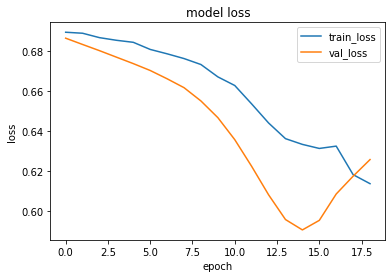

1it [00:00, 18477.11it/s]
file is another_control.mov, prediction is [[0.41159463]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.4778488]]
1it [00:00, 16644.06it/s]
file is control_far.mov, prediction is [[0.4027664]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.4431351]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.40687597]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.5338205]]
Epoch 1/50
3/3 [==============================] - 0s 168ms/step - loss: 0.6238 - accuracy: 0.7125 - val_loss: 0.5704 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6223 - accuracy: 0.6875 - val_loss: 0.5753 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 157ms/step - loss: 0.6102 - accuracy: 0.7000 - val_loss: 0.5853 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6122 

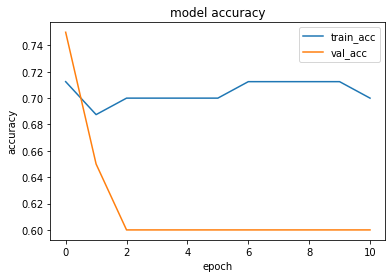

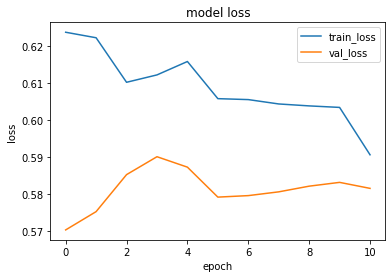

1it [00:00, 16980.99it/s]
file is another_control.mov, prediction is [[0.36049962]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.5786962]]
1it [00:00, 17476.27it/s]
file is control_far.mov, prediction is [[0.3059317]]
1it [00:00, 19239.93it/s]
file is long_armflapping.mov, prediction is [[0.48042455]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.39150274]]
1it [00:00, 14266.34it/s]
file is me_armflapping.mov, prediction is [[0.6445765]]
Epoch 1/50
3/3 [==============================] - 0s 159ms/step - loss: 0.5881 - accuracy: 0.6625 - val_loss: 0.5803 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 151ms/step - loss: 0.5932 - accuracy: 0.6750 - val_loss: 0.5789 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 149ms/step - loss: 0.5868 - accuracy: 0.6750 - val_loss: 0.5822 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5810

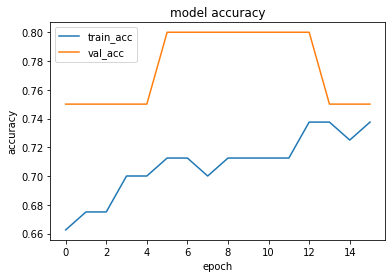

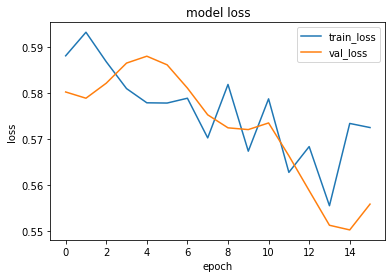

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.11002466]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.6658503]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.06857517]]
1it [00:00, 17189.77it/s]
file is long_armflapping.mov, prediction is [[0.5963253]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.4212332]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.70086795]]
Epoch 1/50
3/3 [==============================] - 0s 161ms/step - loss: 0.5511 - accuracy: 0.7500 - val_loss: 0.5976 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 163ms/step - loss: 0.5551 - accuracy: 0.7375 - val_loss: 0.6122 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 155ms/step - loss: 0.5446 - accuracy: 0.7500 - val_loss: 0.6134 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5477

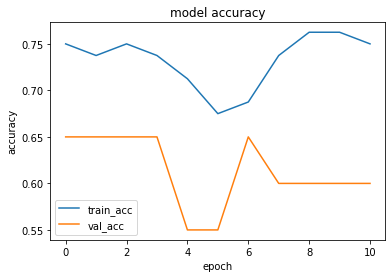

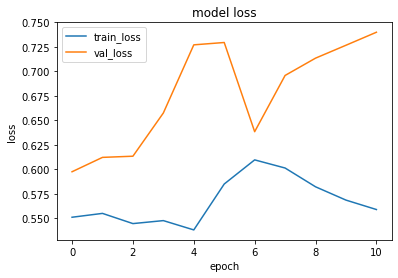

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.12205949]]
1it [00:00, 18558.87it/s]
file is short_armflapping.mov, prediction is [[0.6983153]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.12173265]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.12350136]]
1it [00:00, 17549.39it/s]
file is me_reading_control.mov, prediction is [[0.12161756]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.12578297]]
Epoch 1/50
3/3 [==============================] - 0s 171ms/step - loss: 0.6266 - accuracy: 0.6875 - val_loss: 0.4862 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6137 - accuracy: 0.6875 - val_loss: 0.4879 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6154 - accuracy: 0.6750 - val_loss: 0.4904 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 153ms/step - loss: 0.60

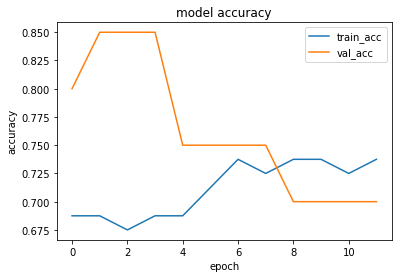

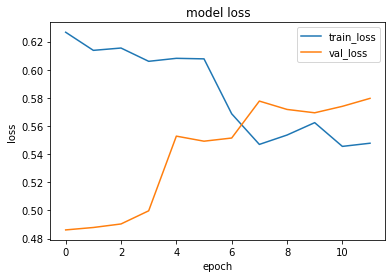

1it [00:00, 18315.74it/s]
file is another_control.mov, prediction is [[0.5722149]]
1it [00:00, 18236.10it/s]
file is short_armflapping.mov, prediction is [[0.6710486]]
1it [00:00, 17331.83it/s]
file is control_far.mov, prediction is [[0.21459317]]
1it [00:00, 18236.10it/s]
file is long_armflapping.mov, prediction is [[0.6270844]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.40759775]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.6702386]]
using aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 256ms/step - loss: 0.6941 - accuracy: 0.7000 - val_loss: 0.6923 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6912 - accuracy: 0.6875 - val_loss: 0.6920 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6927 - accuracy: 0.6500 - val_loss: 0.6916 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 1

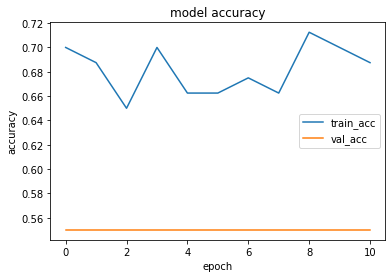

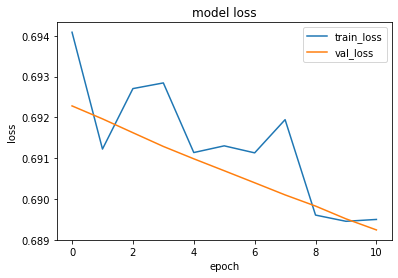

1it [00:00, 18477.11it/s]
file is another_control.mov, prediction is [[0.49758175]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.5056625]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.49681827]]
1it [00:00, 18236.10it/s]
file is long_armflapping.mov, prediction is [[0.4993478]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.49687305]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.49876216]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6904 - accuracy: 0.6375 - val_loss: 0.6882 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6868 - accuracy: 0.6625 - val_loss: 0.6878 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 1s 216ms/step - loss: 0.6889 - accuracy: 0.6625 - val_loss: 0.6875 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 148ms/step - loss: 0.689

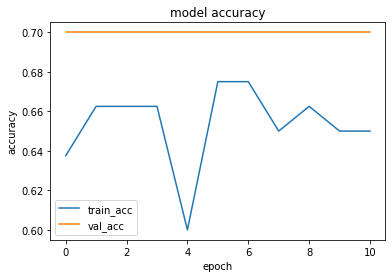

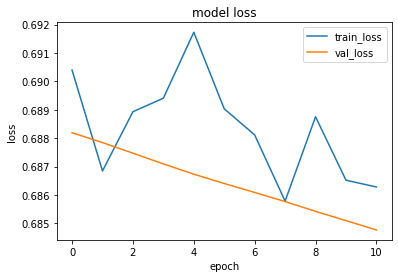

1it [00:00, 18236.10it/s]
file is another_control.mov, prediction is [[0.49737924]]
1it [00:00, 17848.10it/s]
file is short_armflapping.mov, prediction is [[0.50613946]]
1it [00:00, 16320.25it/s]
file is control_far.mov, prediction is [[0.49640214]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.49967992]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.49639875]]
1it [00:00, 18808.54it/s]
file is me_armflapping.mov, prediction is [[0.49993163]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6854 - accuracy: 0.6875 - val_loss: 0.6875 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6870 - accuracy: 0.6750 - val_loss: 0.6871 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6869 - accuracy: 0.6875 - val_loss: 0.6868 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6

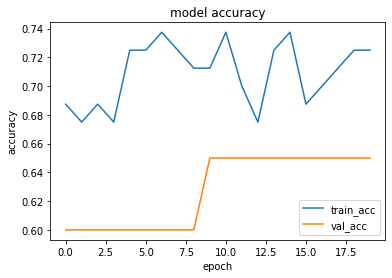

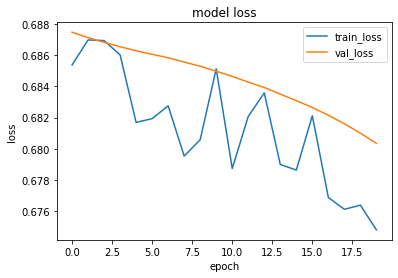

1it [00:00, 14217.98it/s]
file is another_control.mov, prediction is [[0.49207264]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.5031246]]
1it [00:00, 6842.26it/s]
file is control_far.mov, prediction is [[0.49052763]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.4958208]]
1it [00:00, 14768.68it/s]
file is me_reading_control.mov, prediction is [[0.49037397]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.4983328]]
Epoch 1/50
3/3 [==============================] - 0s 167ms/step - loss: 0.6706 - accuracy: 0.7500 - val_loss: 0.6801 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6718 - accuracy: 0.7000 - val_loss: 0.6792 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 149ms/step - loss: 0.6691 - accuracy: 0.7250 - val_loss: 0.6784 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 142ms/step - loss: 0.6691 

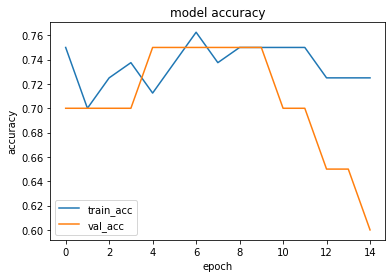

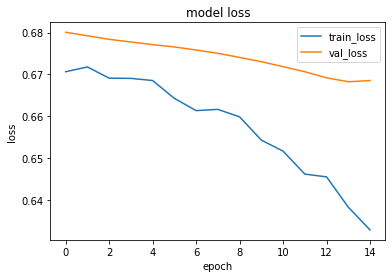

1it [00:00, 18477.11it/s]
file is another_control.mov, prediction is [[0.5007418]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.53008974]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.49701798]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.512387]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.49660224]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.5335073]]
Epoch 1/50
3/3 [==============================] - 0s 165ms/step - loss: 0.6286 - accuracy: 0.6875 - val_loss: 0.6477 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 155ms/step - loss: 0.6268 - accuracy: 0.6625 - val_loss: 0.6502 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6198 - accuracy: 0.6625 - val_loss: 0.6551 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6186 

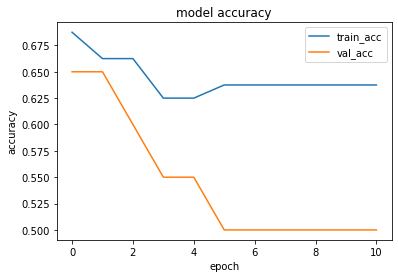

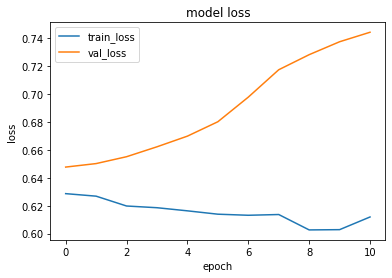

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.51169103]]
1it [00:00, 19239.93it/s]
file is short_armflapping.mov, prediction is [[0.5670065]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.50372374]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.5341894]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.51074356]]
1it [00:00, 18808.54it/s]
file is me_armflapping.mov, prediction is [[0.57283115]]
onto model 1
using no aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 248ms/step - loss: 0.6921 - accuracy: 0.5000 - val_loss: 0.6743 - val_accuracy: 0.4000
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.6867 - accuracy: 0.6125 - val_loss: 0.6572 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6670 - accuracy: 0.7000 - val_loss: 0.6295 - val_accuracy: 0.6500
Epoch 4/50
3/3 [======================

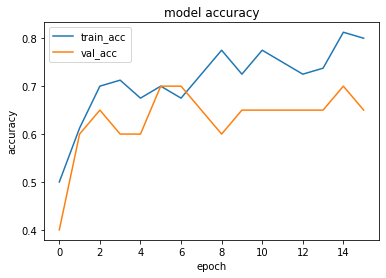

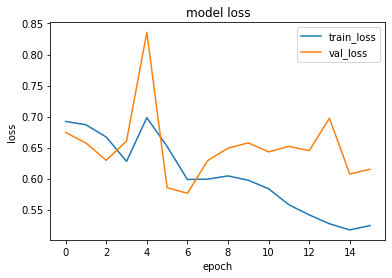

1it [00:00, 17189.77it/s]
file is another_control.mov, prediction is [[0.22883204]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.59684163]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.21399409]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.32894754]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.20551461]]
1it [00:00, 18558.87it/s]
file is me_armflapping.mov, prediction is [[0.68524885]]
Epoch 1/50
3/3 [==============================] - 0s 161ms/step - loss: 0.5635 - accuracy: 0.7375 - val_loss: 0.6168 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 143ms/step - loss: 0.5850 - accuracy: 0.7250 - val_loss: 0.6617 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6202 - accuracy: 0.7125 - val_loss: 0.6086 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6

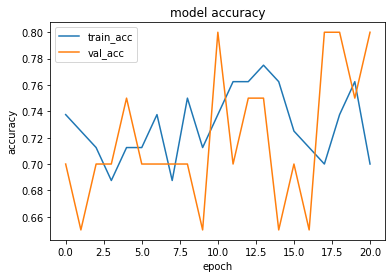

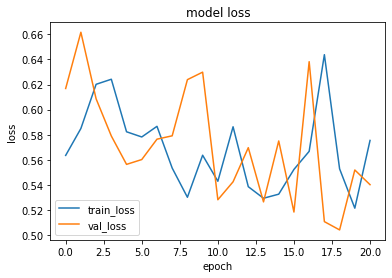

1it [00:00, 12018.06it/s]
file is another_control.mov, prediction is [[0.21808195]]
1it [00:00, 15827.56it/s]
file is short_armflapping.mov, prediction is [[0.50545585]]
1it [00:00, 15141.89it/s]
file is control_far.mov, prediction is [[0.20958403]]
1it [00:00, 22671.91it/s]
file is long_armflapping.mov, prediction is [[0.25569004]]
1it [00:00, 19239.93it/s]
file is me_reading_control.mov, prediction is [[0.20772982]]
1it [00:00, 17772.47it/s]
file is me_armflapping.mov, prediction is [[0.51310843]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.5694 - accuracy: 0.7500 - val_loss: 0.6722 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 142ms/step - loss: 0.5819 - accuracy: 0.6875 - val_loss: 0.6146 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 151ms/step - loss: 0.5699 - accuracy: 0.7375 - val_loss: 0.6234 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5

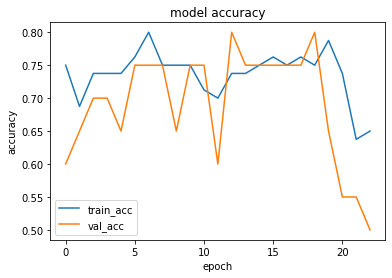

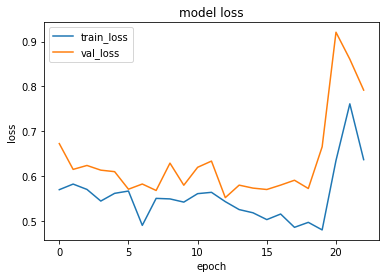

1it [00:00, 16320.25it/s]
file is another_control.mov, prediction is [[0.29061013]]
1it [00:00, 10180.35it/s]
file is short_armflapping.mov, prediction is [[0.44022092]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.30457586]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.31599092]]
1it [00:00, 18808.54it/s]
file is me_reading_control.mov, prediction is [[0.29891914]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.35592306]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6433 - accuracy: 0.6625 - val_loss: 0.6395 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.6245 - accuracy: 0.6875 - val_loss: 0.6868 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6326 - accuracy: 0.6750 - val_loss: 0.7118 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6

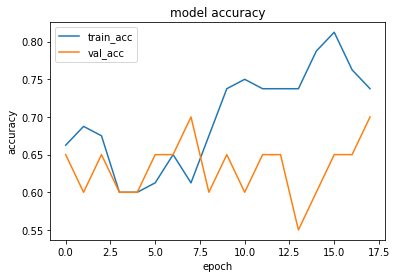

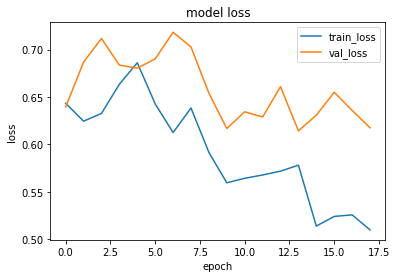

1it [00:00, 8867.45it/s]
file is another_control.mov, prediction is [[0.23943403]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.39269543]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.24323407]]
1it [00:00, 18236.10it/s]
file is long_armflapping.mov, prediction is [[0.27734143]]
1it [00:00, 16912.52it/s]
file is me_reading_control.mov, prediction is [[0.23622683]]
1it [00:00, 17623.13it/s]
file is me_armflapping.mov, prediction is [[0.63645506]]
Epoch 1/50
3/3 [==============================] - 0s 155ms/step - loss: 0.5664 - accuracy: 0.7000 - val_loss: 0.4409 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5322 - accuracy: 0.7375 - val_loss: 0.4498 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.5997 - accuracy: 0.7125 - val_loss: 0.8776 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.63

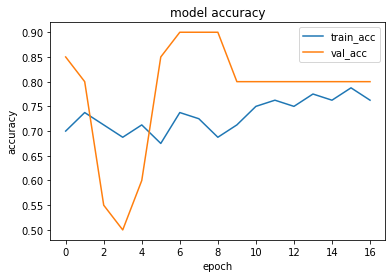

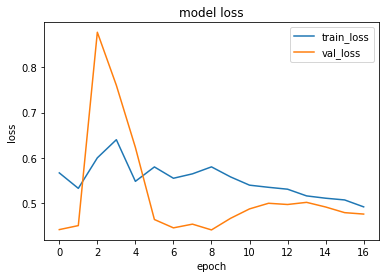

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.22441593]]
1it [00:00, 17772.47it/s]
file is short_armflapping.mov, prediction is [[0.85251945]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.21787468]]
1it [00:00, 17924.38it/s]
file is long_armflapping.mov, prediction is [[0.6968683]]
1it [00:00, 12710.01it/s]
file is me_reading_control.mov, prediction is [[0.21413192]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.77535456]]
using no aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 289ms/step - loss: 0.6949 - accuracy: 0.4375 - val_loss: 0.6923 - val_accuracy: 0.3500
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6915 - accuracy: 0.5875 - val_loss: 0.6903 - val_accuracy: 0.4000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6932 - accuracy: 0.5875 - val_loss: 0.6887 - val_accuracy: 0.4000
Epoch 4/50
3/3 [==============================] -

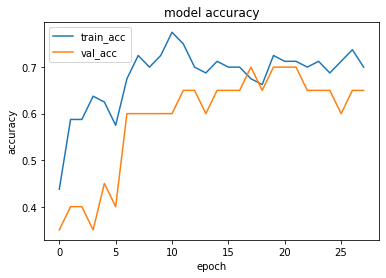

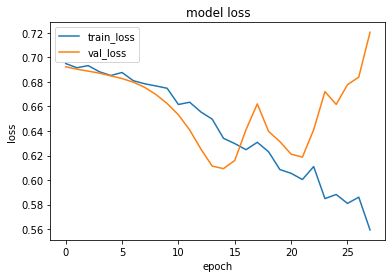

1it [00:00, 14266.34it/s]
file is another_control.mov, prediction is [[0.14945802]]
1it [00:00, 14027.77it/s]
file is short_armflapping.mov, prediction is [[0.27392384]]
1it [00:00, 17189.77it/s]
file is control_far.mov, prediction is [[0.14577597]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.16514534]]
1it [00:00, 18477.11it/s]
file is me_reading_control.mov, prediction is [[0.15090758]]
1it [00:00, 19239.93it/s]
file is me_armflapping.mov, prediction is [[0.23094627]]
Epoch 1/50
3/3 [==============================] - 0s 161ms/step - loss: 0.6169 - accuracy: 0.6625 - val_loss: 0.5814 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6025 - accuracy: 0.6750 - val_loss: 0.5894 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 127ms/step - loss: 0.5916 - accuracy: 0.6875 - val_loss: 0.6023 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5

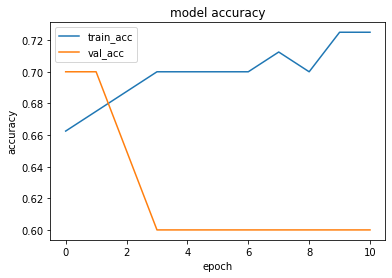

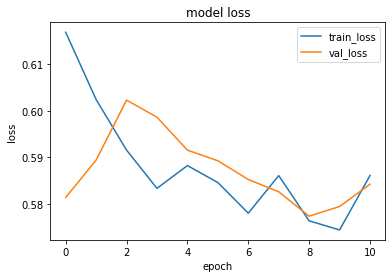

1it [00:00, 17189.77it/s]
file is another_control.mov, prediction is [[0.2364063]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.58146775]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.20881653]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.38923085]]
1it [00:00, 17924.38it/s]
file is me_reading_control.mov, prediction is [[0.29513773]]
1it [00:00, 17924.38it/s]
file is me_armflapping.mov, prediction is [[0.6287695]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5800 - accuracy: 0.6750 - val_loss: 0.5705 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.5740 - accuracy: 0.6875 - val_loss: 0.5735 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 142ms/step - loss: 0.5791 - accuracy: 0.6625 - val_loss: 0.5770 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 139ms/step - loss: 0.574

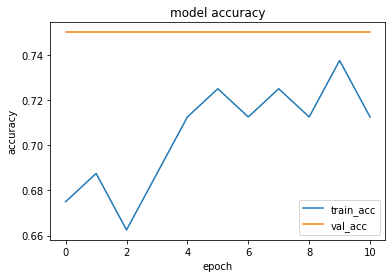

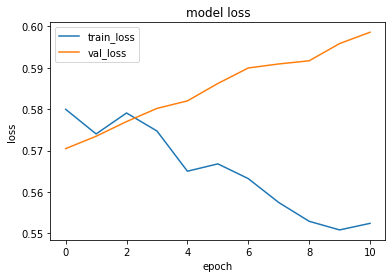

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.32425675]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.55580914]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.25304434]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.46803588]]
1it [00:00, 18477.11it/s]
file is me_reading_control.mov, prediction is [[0.32329684]]
1it [00:00, 18236.10it/s]
file is me_armflapping.mov, prediction is [[0.61435646]]
Epoch 1/50
3/3 [==============================] - 0s 158ms/step - loss: 0.5525 - accuracy: 0.7375 - val_loss: 0.5721 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.5400 - accuracy: 0.7375 - val_loss: 0.5740 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5488 - accuracy: 0.7250 - val_loss: 0.5845 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5

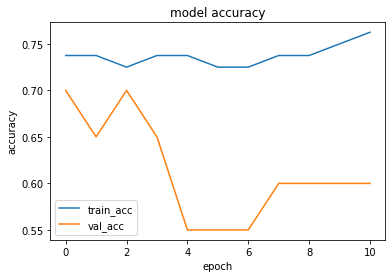

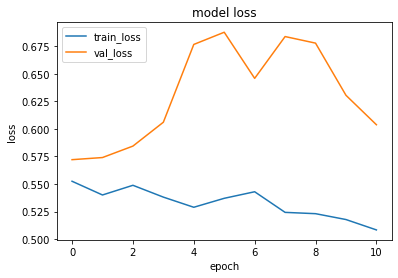

1it [00:00, 14513.16it/s]
file is another_control.mov, prediction is [[0.07410803]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.586777]]
1it [00:00, 18558.87it/s]
file is control_far.mov, prediction is [[0.0285342]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.4865964]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.25721186]]
1it [00:00, 17549.39it/s]
file is me_armflapping.mov, prediction is [[0.64572895]]
Epoch 1/50
3/3 [==============================] - 0s 150ms/step - loss: 0.5440 - accuracy: 0.7250 - val_loss: 0.5138 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 139ms/step - loss: 0.5451 - accuracy: 0.7125 - val_loss: 0.5718 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.5351 - accuracy: 0.7250 - val_loss: 0.5969 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5424 

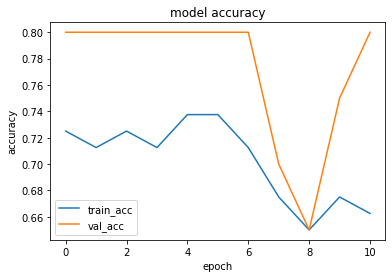

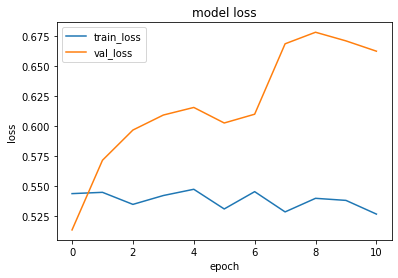

1it [00:00, 12372.58it/s]
file is another_control.mov, prediction is [[0.01492125]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.6383775]]
1it [00:00, 15887.52it/s]
file is control_far.mov, prediction is [[0.01471442]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.5910312]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.01505551]]
1it [00:00, 13662.23it/s]
file is me_armflapping.mov, prediction is [[0.67183334]]
using no aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 240ms/step - loss: 0.6865 - accuracy: 0.6875 - val_loss: 0.6829 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6859 - accuracy: 0.7375 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6857 - accuracy: 0.7000 - val_loss: 0.6813 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] -

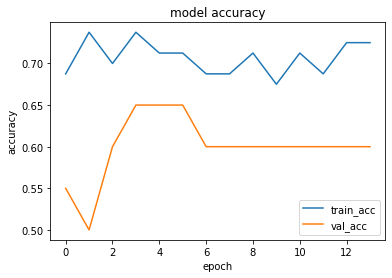

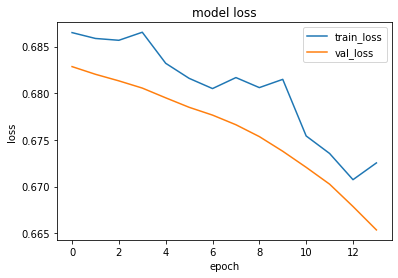

1it [00:00, 17260.51it/s]
file is another_control.mov, prediction is [[0.47606805]]
1it [00:00, 10591.68it/s]
file is short_armflapping.mov, prediction is [[0.49307105]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.4728091]]
1it [00:00, 17848.10it/s]
file is long_armflapping.mov, prediction is [[0.48488194]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.47150972]]
1it [00:00, 18477.11it/s]
file is me_armflapping.mov, prediction is [[0.50763506]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6681 - accuracy: 0.6750 - val_loss: 0.6503 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6626 - accuracy: 0.7125 - val_loss: 0.6451 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6683 - accuracy: 0.6875 - val_loss: 0.6391 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.66

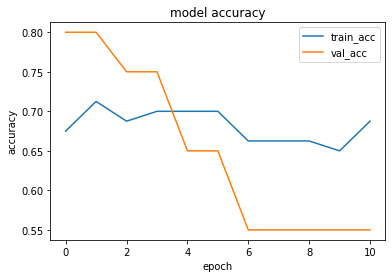

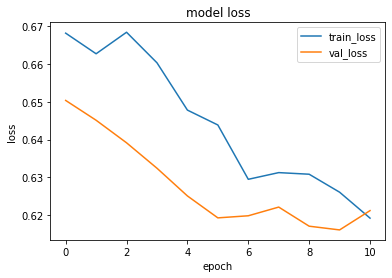

1it [00:00, 12446.01it/s]
file is another_control.mov, prediction is [[0.3565479]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.5060174]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.3431447]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.40457997]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.36822197]]
1it [00:00, 17924.38it/s]
file is me_armflapping.mov, prediction is [[0.5113697]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6236 - accuracy: 0.6250 - val_loss: 0.5848 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6194 - accuracy: 0.6250 - val_loss: 0.5877 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 145ms/step - loss: 0.6039 - accuracy: 0.6625 - val_loss: 0.5940 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6100 

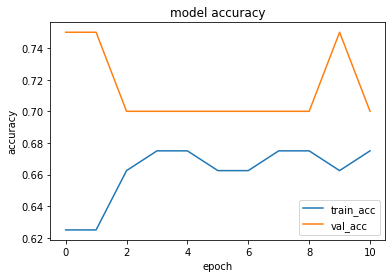

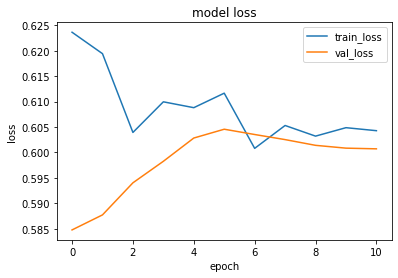

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.3301496]]
1it [00:00, 16644.06it/s]
file is short_armflapping.mov, prediction is [[0.48582408]]
1it [00:00, 16131.94it/s]
file is control_far.mov, prediction is [[0.30883282]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.3950694]]
1it [00:00, 16384.00it/s]
file is me_reading_control.mov, prediction is [[0.3443048]]
1it [00:00, 18558.87it/s]
file is me_armflapping.mov, prediction is [[0.51857585]]
Epoch 1/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5893 - accuracy: 0.7250 - val_loss: 0.6404 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 150ms/step - loss: 0.5872 - accuracy: 0.7250 - val_loss: 0.6467 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.5791 - accuracy: 0.7250 - val_loss: 0.6547 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 127ms/step - loss: 0.5899

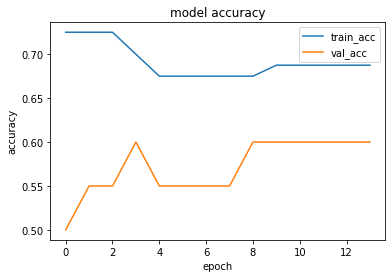

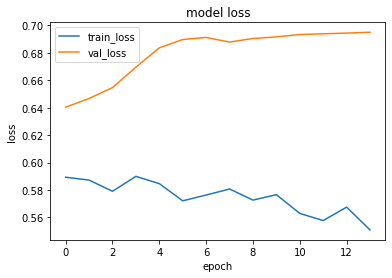

1it [00:00, 12787.51it/s]
file is another_control.mov, prediction is [[0.16560388]]
1it [00:00, 15887.52it/s]
file is short_armflapping.mov, prediction is [[0.57199633]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.12238851]]
1it [00:00, 17623.13it/s]
file is long_armflapping.mov, prediction is [[0.38062775]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.267092]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.6011591]]
Epoch 1/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6062 - accuracy: 0.6500 - val_loss: 0.5063 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6117 - accuracy: 0.6500 - val_loss: 0.5098 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 181ms/step - loss: 0.5985 - accuracy: 0.6500 - val_loss: 0.5151 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 141ms/step - loss: 0.5929

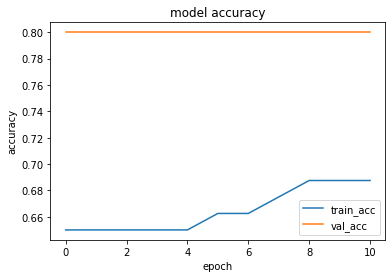

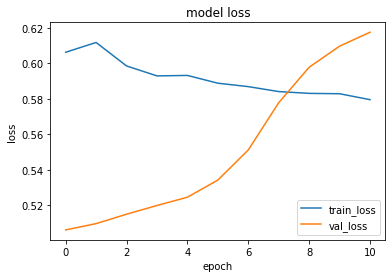

1it [00:00, 11915.64it/s]
file is another_control.mov, prediction is [[0.30899966]]
1it [00:00, 18236.10it/s]
file is short_armflapping.mov, prediction is [[0.5337643]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.21406138]]
1it [00:00, 18477.11it/s]
file is long_armflapping.mov, prediction is [[0.44987303]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.34709606]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.5803327]]
using no aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 253ms/step - loss: 0.6996 - accuracy: 0.4125 - val_loss: 0.7018 - val_accuracy: 0.3500
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.7019 - accuracy: 0.4750 - val_loss: 0.7016 - val_accuracy: 0.3500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.7004 - accuracy: 0.5000 - val_loss: 0.7014 - val_accuracy: 0.3500
Epoch 4/50
3/3 [==============================] -

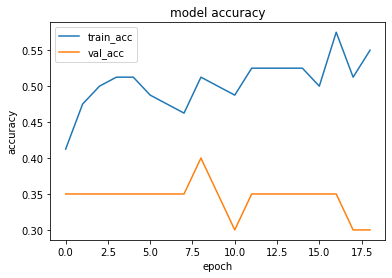

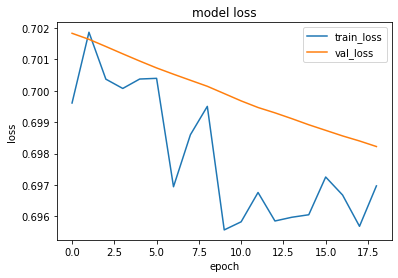

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.49757004]]
1it [00:00, 11618.57it/s]
file is short_armflapping.mov, prediction is [[0.49111184]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.49848503]]
1it [00:00, 17623.13it/s]
file is long_armflapping.mov, prediction is [[0.49580932]]
1it [00:00, 18477.11it/s]
file is me_reading_control.mov, prediction is [[0.49822313]]
1it [00:00, 17260.51it/s]
file is me_armflapping.mov, prediction is [[0.4905369]]
Epoch 1/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6947 - accuracy: 0.4625 - val_loss: 0.6957 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 146ms/step - loss: 0.6974 - accuracy: 0.4500 - val_loss: 0.6954 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6950 - accuracy: 0.4500 - val_loss: 0.6952 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.69

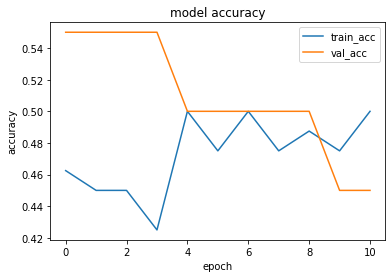

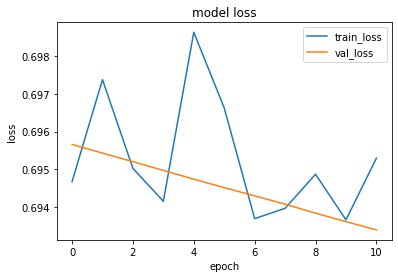

1it [00:00, 15592.21it/s]
file is another_control.mov, prediction is [[0.498862]]
1it [00:00, 17924.38it/s]
file is short_armflapping.mov, prediction is [[0.49385452]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.499426]]
1it [00:00, 18558.87it/s]
file is long_armflapping.mov, prediction is [[0.49789694]]
1it [00:00, 19599.55it/s]
file is me_reading_control.mov, prediction is [[0.4990535]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.49429128]]
Epoch 1/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6956 - accuracy: 0.4875 - val_loss: 0.6927 - val_accuracy: 0.5500
Epoch 2/50
3/3 [==============================] - 0s 197ms/step - loss: 0.6953 - accuracy: 0.4500 - val_loss: 0.6925 - val_accuracy: 0.5500
Epoch 3/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6953 - accuracy: 0.4750 - val_loss: 0.6923 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6898 -

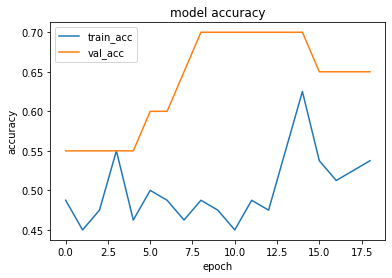

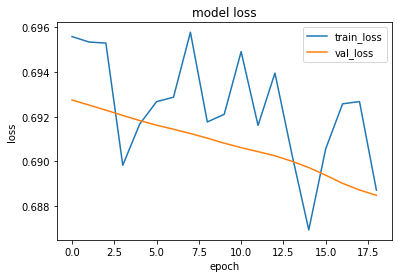

1it [00:00, 14665.40it/s]
file is another_control.mov, prediction is [[0.4983016]]
1it [00:00, 12787.51it/s]
file is short_armflapping.mov, prediction is [[0.4961233]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.4982915]]
1it [00:00, 18558.87it/s]
file is long_armflapping.mov, prediction is [[0.49876633]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.4977171]]
1it [00:00, 16710.37it/s]
file is me_armflapping.mov, prediction is [[0.49837896]]
Epoch 1/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6879 - accuracy: 0.5625 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.6890 - accuracy: 0.6125 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6899 - accuracy: 0.5875 - val_loss: 0.6911 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6880 

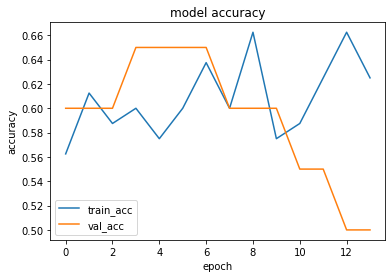

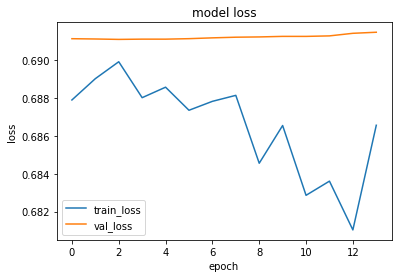

1it [00:00, 17924.38it/s]
file is another_control.mov, prediction is [[0.5012654]]
1it [00:00, 15650.39it/s]
file is short_armflapping.mov, prediction is [[0.50236714]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.5007086]]
1it [00:00, 17924.38it/s]
file is long_armflapping.mov, prediction is [[0.50336134]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.49983737]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.50715184]]
Epoch 1/50
3/3 [==============================] - 0s 148ms/step - loss: 0.6837 - accuracy: 0.6000 - val_loss: 0.6851 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6820 - accuracy: 0.5750 - val_loss: 0.6846 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6790 - accuracy: 0.6000 - val_loss: 0.6841 - val_accuracy: 0.4500
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 0.682

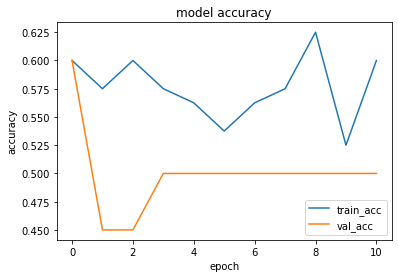

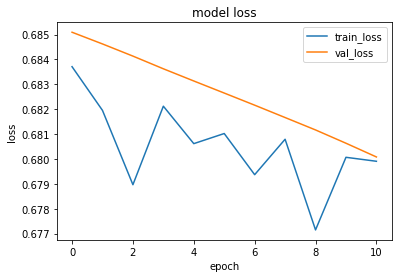

1it [00:00, 14122.24it/s]
file is another_control.mov, prediction is [[0.5036066]]
1it [00:00, 11881.88it/s]
file is short_armflapping.mov, prediction is [[0.5077703]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.5026646]]
1it [00:00, 17476.27it/s]
file is long_armflapping.mov, prediction is [[0.5071856]]
1it [00:00, 19239.93it/s]
file is me_reading_control.mov, prediction is [[0.50161254]]
1it [00:00, 17476.27it/s]
file is me_armflapping.mov, prediction is [[0.5151422]]
using aug with lr 0.01
Epoch 1/50
3/3 [==============================] - 1s 246ms/step - loss: 0.6930 - accuracy: 0.5250 - val_loss: 0.6786 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 128ms/step - loss: 0.6511 - accuracy: 0.7375 - val_loss: 0.6321 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.7031 - accuracy: 0.6125 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 129m

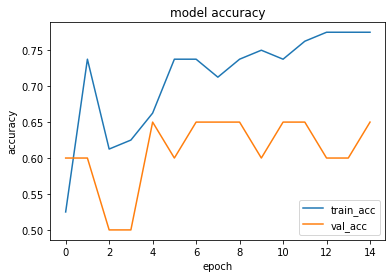

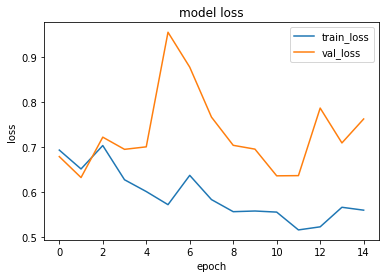

1it [00:00, 4951.95it/s]
file is another_control.mov, prediction is [[0.17825216]]
1it [00:00, 16980.99it/s]
file is short_armflapping.mov, prediction is [[0.1855905]]
1it [00:00, 13706.88it/s]
file is control_far.mov, prediction is [[0.17722818]]
1it [00:00, 15887.52it/s]
file is long_armflapping.mov, prediction is [[0.18104148]]
1it [00:00, 13315.25it/s]
file is me_reading_control.mov, prediction is [[0.17710337]]
1it [00:00, 14979.66it/s]
file is me_armflapping.mov, prediction is [[0.1860232]]
Epoch 1/50
3/3 [==============================] - 0s 139ms/step - loss: 0.6235 - accuracy: 0.7125 - val_loss: 0.6470 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6094 - accuracy: 0.6875 - val_loss: 0.6645 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 178ms/step - loss: 0.5851 - accuracy: 0.6875 - val_loss: 0.5309 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 158ms/step - loss: 0.6296

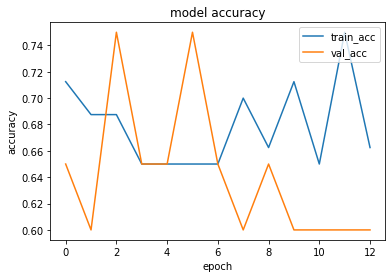

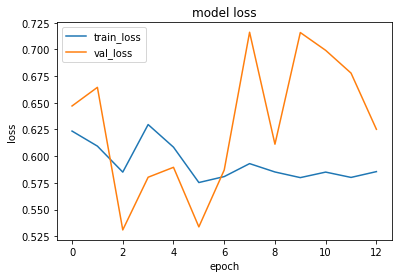

1it [00:00, 15141.89it/s]
file is another_control.mov, prediction is [[0.35289335]]
1it [00:00, 13315.25it/s]
file is short_armflapping.mov, prediction is [[0.34764576]]
1it [00:00, 18477.11it/s]
file is control_far.mov, prediction is [[0.3518075]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.3562104]]
1it [00:00, 18315.74it/s]
file is me_reading_control.mov, prediction is [[0.3516355]]
1it [00:00, 15887.52it/s]
file is me_armflapping.mov, prediction is [[0.36441845]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6006 - accuracy: 0.6750 - val_loss: 0.4330 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.5994 - accuracy: 0.6750 - val_loss: 0.5420 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5680 - accuracy: 0.7000 - val_loss: 0.6447 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6233

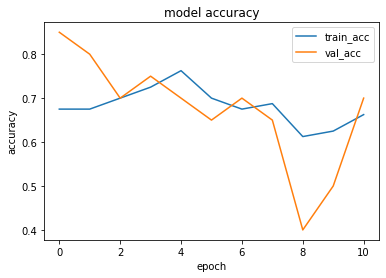

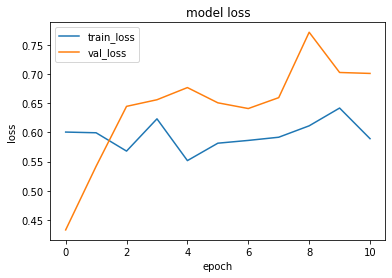

1it [00:00, 14768.68it/s]
file is another_control.mov, prediction is [[0.49718234]]
1it [00:00, 14768.68it/s]
file is short_armflapping.mov, prediction is [[0.5903531]]
1it [00:00, 14768.68it/s]
file is control_far.mov, prediction is [[0.4897881]]
1it [00:00, 12300.01it/s]
file is long_armflapping.mov, prediction is [[0.51393294]]
1it [00:00, 17623.13it/s]
file is me_reading_control.mov, prediction is [[0.4887068]]
1it [00:00, 15592.21it/s]
file is me_armflapping.mov, prediction is [[0.5492597]]
Epoch 1/50
3/3 [==============================] - 0s 171ms/step - loss: 0.6215 - accuracy: 0.6125 - val_loss: 0.6598 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 144ms/step - loss: 0.6085 - accuracy: 0.6875 - val_loss: 0.6959 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5699 - accuracy: 0.6875 - val_loss: 0.7571 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 136ms/step - loss: 0.5765 

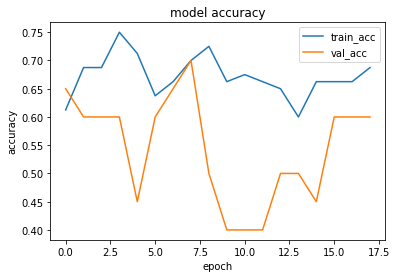

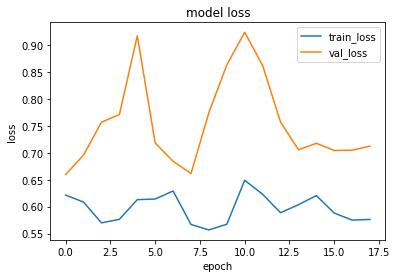

1it [00:00, 14873.42it/s]
file is another_control.mov, prediction is [[0.48763275]]
1it [00:00, 14665.40it/s]
file is short_armflapping.mov, prediction is [[0.6038126]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.48633435]]
1it [00:00, 16070.13it/s]
file is long_armflapping.mov, prediction is [[0.2758329]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.261085]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.29628187]]
Epoch 1/50
3/3 [==============================] - 0s 152ms/step - loss: 0.6527 - accuracy: 0.5625 - val_loss: 0.5058 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6131 - accuracy: 0.6375 - val_loss: 0.5070 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 172ms/step - loss: 0.6260 - accuracy: 0.5875 - val_loss: 0.5122 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 127ms/step - loss: 0.6286 

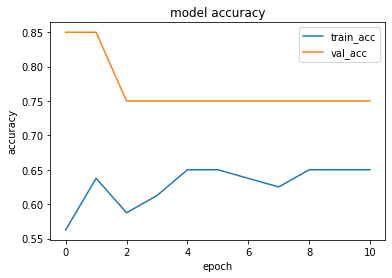

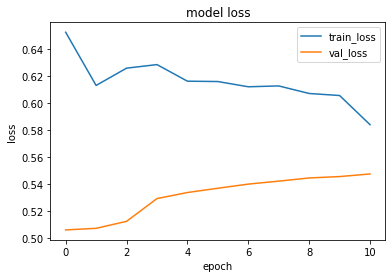

1it [00:00, 14716.86it/s]
file is another_control.mov, prediction is [[0.4022294]]
1it [00:00, 16710.37it/s]
file is short_armflapping.mov, prediction is [[0.6536983]]
1it [00:00, 18157.16it/s]
file is control_far.mov, prediction is [[0.3905453]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.4290091]]
1it [00:00, 16320.25it/s]
file is me_reading_control.mov, prediction is [[0.38783234]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.47245795]]
using aug with lr 0.001
Epoch 1/50
3/3 [==============================] - 1s 230ms/step - loss: 0.6890 - accuracy: 0.5500 - val_loss: 0.6858 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 150ms/step - loss: 0.6884 - accuracy: 0.6750 - val_loss: 0.6849 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6877 - accuracy: 0.6875 - val_loss: 0.6839 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 12

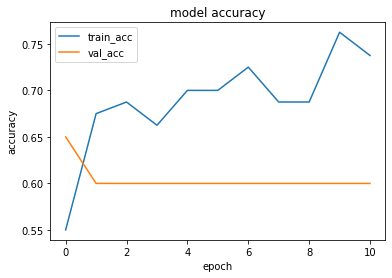

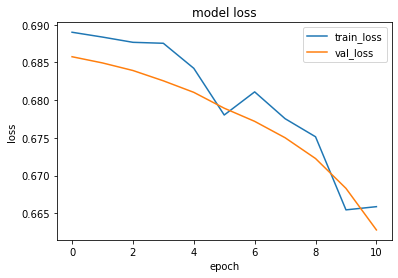

1it [00:00, 14665.40it/s]
file is another_control.mov, prediction is [[0.46997583]]
1it [00:00, 16131.94it/s]
file is short_armflapping.mov, prediction is [[0.4863766]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.46670628]]
1it [00:00, 17772.47it/s]
file is long_armflapping.mov, prediction is [[0.47965714]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.46430698]]
1it [00:00, 18558.87it/s]
file is me_armflapping.mov, prediction is [[0.5019724]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.6702 - accuracy: 0.6875 - val_loss: 0.6411 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 124ms/step - loss: 0.6621 - accuracy: 0.6625 - val_loss: 0.6284 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 128ms/step - loss: 0.6355 - accuracy: 0.6875 - val_loss: 0.6175 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 122ms/step - loss: 0.626

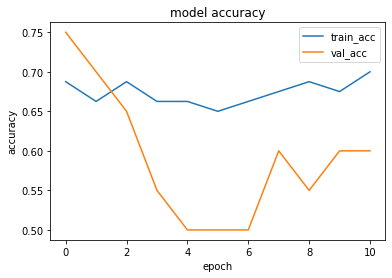

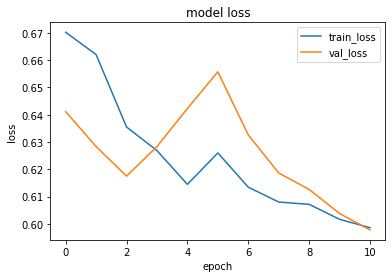

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.2619692]]
1it [00:00, 14926.35it/s]
file is short_armflapping.mov, prediction is [[0.5430718]]
1it [00:00, 14979.66it/s]
file is control_far.mov, prediction is [[0.2318747]]
1it [00:00, 15592.21it/s]
file is long_armflapping.mov, prediction is [[0.38522926]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.31582546]]
1it [00:00, 18157.16it/s]
file is me_armflapping.mov, prediction is [[0.55444694]]
Epoch 1/50
3/3 [==============================] - 0s 156ms/step - loss: 0.5965 - accuracy: 0.6625 - val_loss: 0.5985 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 128ms/step - loss: 0.5920 - accuracy: 0.6625 - val_loss: 0.5966 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 126ms/step - loss: 0.6011 - accuracy: 0.6750 - val_loss: 0.6026 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 125ms/step - loss: 0.5928

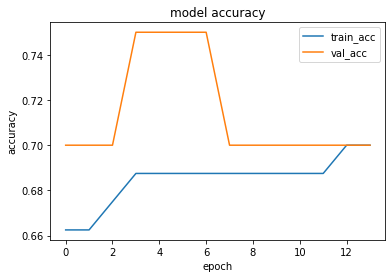

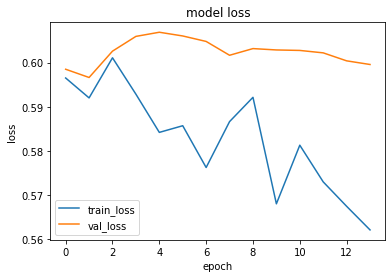

1it [00:00, 13888.42it/s]
file is another_control.mov, prediction is [[0.04846784]]
1it [00:00, 17260.51it/s]
file is short_armflapping.mov, prediction is [[0.54240894]]
1it [00:00, 17848.10it/s]
file is control_far.mov, prediction is [[0.04232594]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.32189167]]
1it [00:00, 15650.39it/s]
file is me_reading_control.mov, prediction is [[0.10560119]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.5664097]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.5590 - accuracy: 0.7125 - val_loss: 0.6455 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 140ms/step - loss: 0.5486 - accuracy: 0.7375 - val_loss: 0.6534 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 138ms/step - loss: 0.5488 - accuracy: 0.7250 - val_loss: 0.6577 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 143ms/step - loss: 0.53

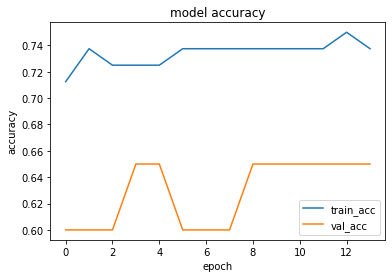

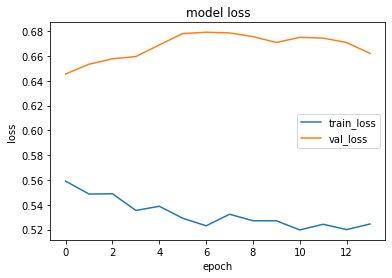

1it [00:00, 14315.03it/s]
file is another_control.mov, prediction is [[0.37922135]]
1it [00:00, 12018.06it/s]
file is short_armflapping.mov, prediction is [[0.6042079]]
1it [00:00, 13231.24it/s]
file is control_far.mov, prediction is [[0.04264006]]
1it [00:00, 15363.75it/s]
file is long_armflapping.mov, prediction is [[0.53211665]]
1it [00:00, 18236.10it/s]
file is me_reading_control.mov, prediction is [[0.3487152]]
1it [00:00, 14926.35it/s]
file is me_armflapping.mov, prediction is [[0.6489809]]
Epoch 1/50
3/3 [==============================] - 1s 202ms/step - loss: 0.5667 - accuracy: 0.6875 - val_loss: 0.4516 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 130ms/step - loss: 0.5628 - accuracy: 0.7125 - val_loss: 0.4949 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 127ms/step - loss: 0.5632 - accuracy: 0.7125 - val_loss: 0.6321 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.5483

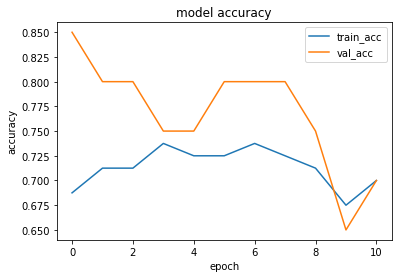

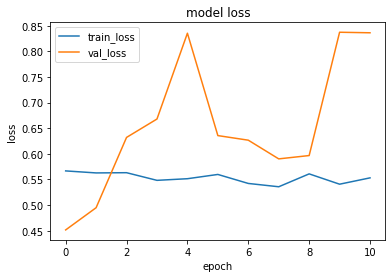

1it [00:00, 9341.43it/s]
file is another_control.mov, prediction is [[0.01637322]]
1it [00:00, 13888.42it/s]
file is short_armflapping.mov, prediction is [[0.646096]]
1it [00:00, 16912.52it/s]
file is control_far.mov, prediction is [[0.01636955]]
1it [00:00, 17549.39it/s]
file is long_armflapping.mov, prediction is [[0.5815733]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.01638049]]
1it [00:00, 19239.93it/s]
file is me_armflapping.mov, prediction is [[0.6747303]]
using aug with lr 0.0005
Epoch 1/50
3/3 [==============================] - 1s 233ms/step - loss: 0.6989 - accuracy: 0.3750 - val_loss: 0.7006 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6920 - accuracy: 0.6500 - val_loss: 0.6990 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 125ms/step - loss: 0.6948 - accuracy: 0.6000 - val_loss: 0.6975 - val_accuracy: 0.5500
Epoch 4/50
3/3 [==============================] - 0s 12

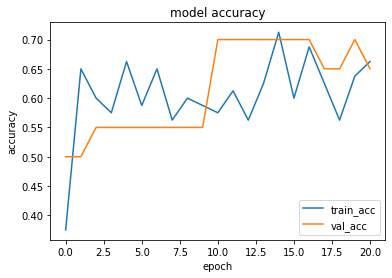

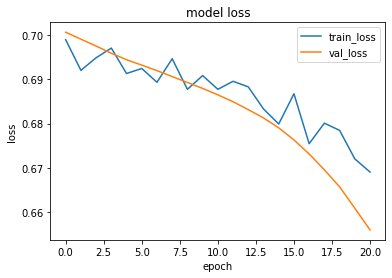

1it [00:00, 18157.16it/s]
file is another_control.mov, prediction is [[0.4766905]]
1it [00:00, 18157.16it/s]
file is short_armflapping.mov, prediction is [[0.4918343]]
1it [00:00, 17476.27it/s]
file is control_far.mov, prediction is [[0.47477686]]
1it [00:00, 18893.26it/s]
file is long_armflapping.mov, prediction is [[0.4814895]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.47423875]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.49311814]]
Epoch 1/50
3/3 [==============================] - 0s 153ms/step - loss: 0.6639 - accuracy: 0.6000 - val_loss: 0.6558 - val_accuracy: 0.7500
Epoch 2/50
3/3 [==============================] - 0s 136ms/step - loss: 0.6598 - accuracy: 0.6750 - val_loss: 0.6505 - val_accuracy: 0.7500
Epoch 3/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6569 - accuracy: 0.6875 - val_loss: 0.6445 - val_accuracy: 0.8500
Epoch 4/50
3/3 [==============================] - 0s 121ms/step - loss: 0.6441

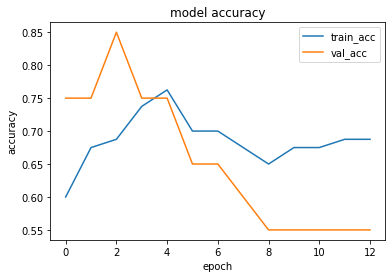

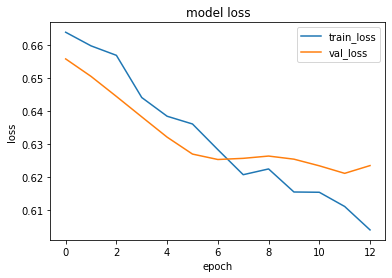

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.5094759]]
1it [00:00, 15650.39it/s]
file is short_armflapping.mov, prediction is [[0.589901]]
1it [00:00, 17549.39it/s]
file is control_far.mov, prediction is [[0.49830896]]
1it [00:00, 17260.51it/s]
file is long_armflapping.mov, prediction is [[0.54271257]]
1it [00:00, 18477.11it/s]
file is me_reading_control.mov, prediction is [[0.50126266]]
1it [00:00, 17476.27it/s]
file is me_armflapping.mov, prediction is [[0.6129792]]
Epoch 1/50
3/3 [==============================] - 0s 156ms/step - loss: 0.6111 - accuracy: 0.6375 - val_loss: 0.6023 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 131ms/step - loss: 0.6065 - accuracy: 0.6375 - val_loss: 0.6034 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6016 - accuracy: 0.6500 - val_loss: 0.6082 - val_accuracy: 0.7500
Epoch 4/50
3/3 [==============================] - 0s 130ms/step - loss: 0.6060 

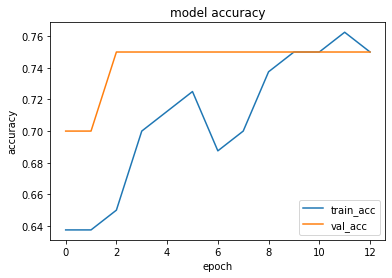

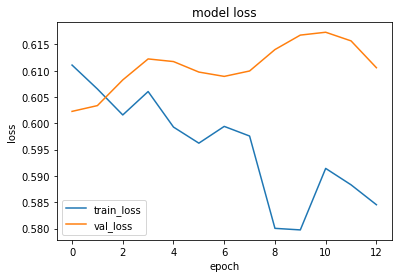

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.3994294]]
1it [00:00, 14122.24it/s]
file is short_armflapping.mov, prediction is [[0.5338078]]
1it [00:00, 16912.52it/s]
file is control_far.mov, prediction is [[0.37991217]]
1it [00:00, 14926.35it/s]
file is long_armflapping.mov, prediction is [[0.45602208]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.38760012]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.5733406]]
Epoch 1/50
3/3 [==============================] - 0s 151ms/step - loss: 0.5720 - accuracy: 0.7375 - val_loss: 0.6101 - val_accuracy: 0.6500
Epoch 2/50
3/3 [==============================] - 0s 126ms/step - loss: 0.5675 - accuracy: 0.7500 - val_loss: 0.6315 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 131ms/step - loss: 0.5612 - accuracy: 0.7500 - val_loss: 0.6589 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.5556

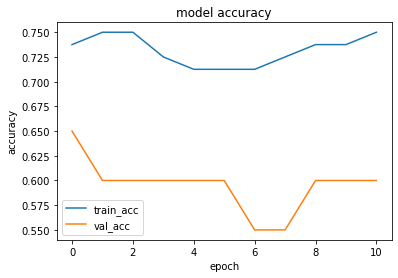

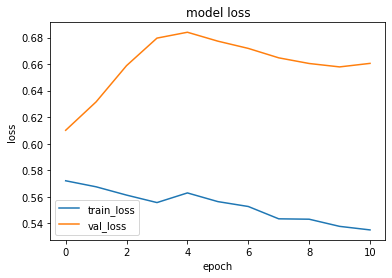

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.18381041]]
1it [00:00, 14926.35it/s]
file is short_armflapping.mov, prediction is [[0.6124284]]
1it [00:00, 17331.83it/s]
file is control_far.mov, prediction is [[0.08885244]]
1it [00:00, 15887.52it/s]
file is long_armflapping.mov, prediction is [[0.4756591]]
1it [00:00, 17476.27it/s]
file is me_reading_control.mov, prediction is [[0.34087443]]
1it [00:00, 14768.68it/s]
file is me_armflapping.mov, prediction is [[0.65407085]]
Epoch 1/50
3/3 [==============================] - 0s 152ms/step - loss: 0.5791 - accuracy: 0.6875 - val_loss: 0.4733 - val_accuracy: 0.8500
Epoch 2/50
3/3 [==============================] - 0s 135ms/step - loss: 0.5670 - accuracy: 0.6875 - val_loss: 0.4845 - val_accuracy: 0.8500
Epoch 3/50
3/3 [==============================] - 0s 130ms/step - loss: 0.5700 - accuracy: 0.7125 - val_loss: 0.5230 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.574

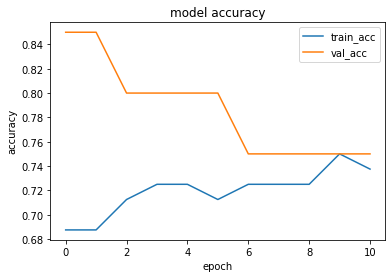

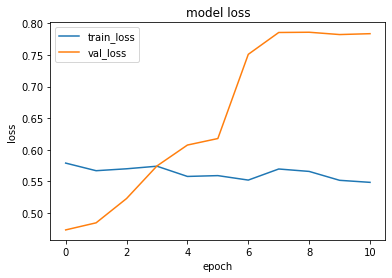

1it [00:00, 12157.40it/s]
file is another_control.mov, prediction is [[0.42268795]]
1it [00:00, 11214.72it/s]
file is short_armflapping.mov, prediction is [[0.6111878]]
1it [00:00, 15420.24it/s]
file is control_far.mov, prediction is [[0.3177314]]
1it [00:00, 15650.39it/s]
file is long_armflapping.mov, prediction is [[0.52775145]]
1it [00:00, 17848.10it/s]
file is me_reading_control.mov, prediction is [[0.40278435]]
1it [00:00, 17848.10it/s]
file is me_armflapping.mov, prediction is [[0.6407891]]
using aug with lr 0.0001
Epoch 1/50
3/3 [==============================] - 1s 286ms/step - loss: 0.6909 - accuracy: 0.6500 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 141ms/step - loss: 0.6912 - accuracy: 0.6500 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6925 - accuracy: 0.6500 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/50
3/3 [==============================] - 0s 

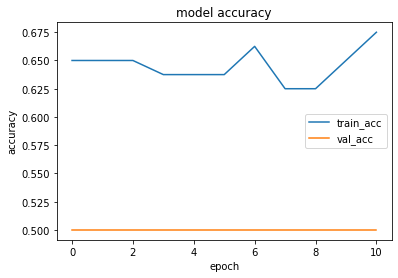

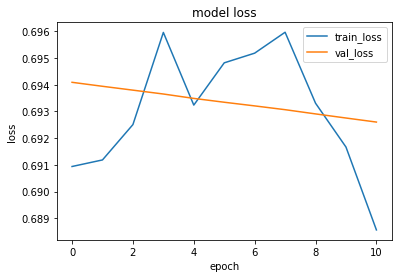

1it [00:00, 17189.77it/s]
file is another_control.mov, prediction is [[0.497722]]
1it [00:00, 15141.89it/s]
file is short_armflapping.mov, prediction is [[0.50598764]]
1it [00:00, 15363.75it/s]
file is control_far.mov, prediction is [[0.4973478]]
1it [00:00, 18157.16it/s]
file is long_armflapping.mov, prediction is [[0.49896312]]
1it [00:00, 17924.38it/s]
file is me_reading_control.mov, prediction is [[0.49723202]]
1it [00:00, 16131.94it/s]
file is me_armflapping.mov, prediction is [[0.504701]]
Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 0.6907 - accuracy: 0.6250 - val_loss: 0.6915 - val_accuracy: 0.7000
Epoch 2/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6941 - accuracy: 0.6000 - val_loss: 0.6913 - val_accuracy: 0.7000
Epoch 3/50
3/3 [==============================] - 0s 134ms/step - loss: 0.6899 - accuracy: 0.6500 - val_loss: 0.6912 - val_accuracy: 0.7000
Epoch 4/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6952 -

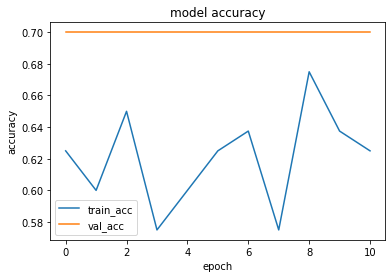

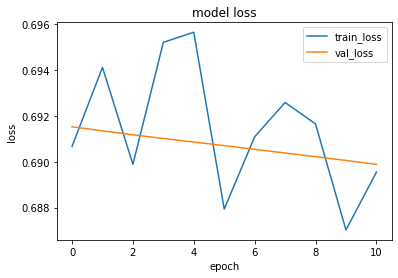

1it [00:00, 15420.24it/s]
file is another_control.mov, prediction is [[0.49787834]]
1it [00:00, 14926.35it/s]
file is short_armflapping.mov, prediction is [[0.50651276]]
1it [00:00, 15141.89it/s]
file is control_far.mov, prediction is [[0.49737605]]
1it [00:00, 16070.13it/s]
file is long_armflapping.mov, prediction is [[0.4994422]]
1it [00:00, 14716.86it/s]
file is me_reading_control.mov, prediction is [[0.49722195]]
1it [00:00, 17924.38it/s]
file is me_armflapping.mov, prediction is [[0.50582623]]
Epoch 1/50
3/3 [==============================] - 0s 142ms/step - loss: 0.6926 - accuracy: 0.6750 - val_loss: 0.6908 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 137ms/step - loss: 0.6904 - accuracy: 0.6750 - val_loss: 0.6906 - val_accuracy: 0.6500
Epoch 3/50
3/3 [==============================] - 0s 132ms/step - loss: 0.6908 - accuracy: 0.6500 - val_loss: 0.6904 - val_accuracy: 0.6500
Epoch 4/50
3/3 [==============================] - 0s 136ms/step - loss: 0.68

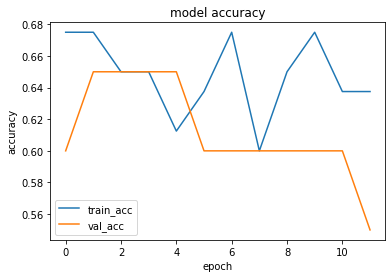

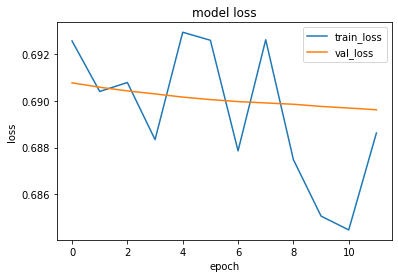

1it [00:00, 16448.25it/s]
file is another_control.mov, prediction is [[0.4962212]]
1it [00:00, 17549.39it/s]
file is short_armflapping.mov, prediction is [[0.505399]]
1it [00:00, 17476.27it/s]
file is control_far.mov, prediction is [[0.4955704]]
1it [00:00, 16194.22it/s]
file is long_armflapping.mov, prediction is [[0.49815962]]
1it [00:00, 18558.87it/s]
file is me_reading_control.mov, prediction is [[0.4953867]]
1it [00:00, 16912.52it/s]
file is me_armflapping.mov, prediction is [[0.5052722]]
Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 0.6863 - accuracy: 0.6625 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 2/50
3/3 [==============================] - 0s 129ms/step - loss: 0.6870 - accuracy: 0.6750 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6859 - accuracy: 0.6250 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 0s 133ms/step - loss: 0.6886 - 

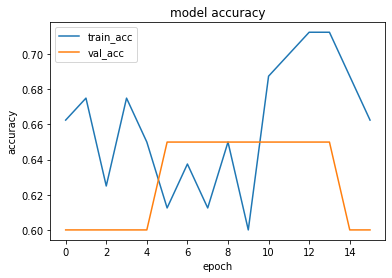

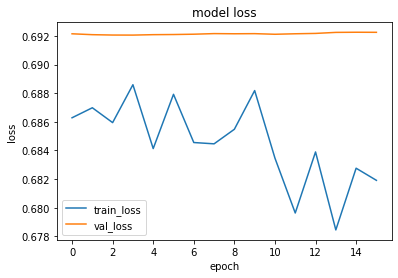

1it [00:00, 16912.52it/s]
file is another_control.mov, prediction is [[0.49771583]]
1it [00:00, 15420.24it/s]
file is short_armflapping.mov, prediction is [[0.50914794]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.49665675]]
1it [00:00, 14217.98it/s]
file is long_armflapping.mov, prediction is [[0.5008198]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.49629405]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.5106147]]
Epoch 1/50
3/3 [==============================] - 0s 147ms/step - loss: 0.6840 - accuracy: 0.6125 - val_loss: 0.6789 - val_accuracy: 0.8000
Epoch 2/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6835 - accuracy: 0.6000 - val_loss: 0.6786 - val_accuracy: 0.8000
Epoch 3/50
3/3 [==============================] - 0s 135ms/step - loss: 0.6880 - accuracy: 0.6000 - val_loss: 0.6783 - val_accuracy: 0.8000
Epoch 4/50
3/3 [==============================] - 0s 132ms/step - loss: 0.687

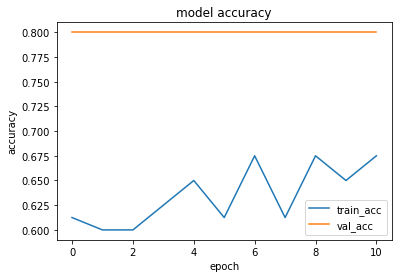

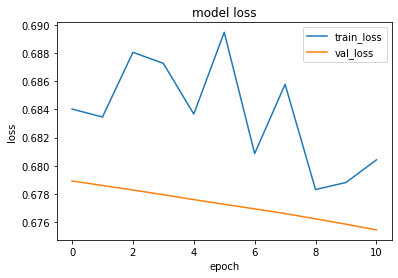

1it [00:00, 14926.35it/s]
file is another_control.mov, prediction is [[0.4992453]]
1it [00:00, 15196.75it/s]
file is short_armflapping.mov, prediction is [[0.51257324]]
1it [00:00, 17924.38it/s]
file is control_far.mov, prediction is [[0.49788058]]
1it [00:00, 15141.89it/s]
file is long_armflapping.mov, prediction is [[0.5033039]]
1it [00:00, 18157.16it/s]
file is me_reading_control.mov, prediction is [[0.4974329]]
1it [00:00, 17549.39it/s]file is me_armflapping.mov, prediction is [[0.5153275]]
onto model 2



In [5]:
from copy import deepcopy
from tqdm import tqdm 
for z, model in enumerate([model_1, model_2]): 
    aug_model = deepcopy(model)
    aug_model.layers.insert(0, Augmenter()) # insert augmentation layer 
    assert model.layers != aug_model.layers
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_accuracy")

    patience = [5, 10]
    
    for i, test_model in enumerate([model, aug_model]):
        for learning_rate in [0.01, 0.001, 0.0005, 0.0001]:
            if z == 0: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(16, return_sequences=False), 
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])
            else: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(8, return_sequences=False), 
                    tf.keras.layers.Dropout(0.2), 
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])

            test_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['accuracy'])    
            print(f"using {['no aug', 'aug'][i]} with lr {learning_rate}")
            try: 
                cross_validate(test_model, callbacks=[early_stopping, accuracy_callback])
            except Exception as e: 
                print(f"failed training because of {e}")
    print(f"onto model {z + 1}")

In [83]:
from tqdm import tqdm 

model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(32, return_sequences = False), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy'])
cross_validate(model, epochs = 30, callbacks=[])

ValueError: zero-dimensional arrays cannot be concatenated

In [60]:
def generate_new_fold(num = 4):
    X_train = np.concatenate([X_j for j, X_j in enumerate(X) if j != num])
    y_train = np.concatenate([y_j for j, y_j in enumerate(y) if j != num]) # don't use the last one 
    X_test, y_test = X[num], y[num]
    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = generate_new_fold(num = 4)

In [42]:
def ensemble_val_acc(models, X_test, y_test): 
    y_pred = np.zeros_like(y_test)
    for model in models: 
        y_pred += model.predict(X_test).flatten()
    y_pred = y_pred / len(models)
    y_pred = np.round_(y_pred)
    return (y_pred == y_test).sum() / y_pred.shape[0]